In [0]:
import os
os.chdir("./drive/My Drive/179skill")

In [0]:
import pyGM as gm
import numpy as np
import matplotlib.pyplot as plt
import random
import time
%matplotlib inline         

In [0]:
def logit(z): return 1./(1.+np.exp(-z))

In [0]:
def generate_players(num_of_players, skill_cap):
    ## returns a list of player's skill
    return [round(random.uniform(0,skill_cap),2) for i in range(num_of_players)]


def generate_games(players, num_of_games, scale=0.3, style='pygm'):

    if style == 'pystan':
        
        player1=[]
        player2=[]
        outcome=[]
        for i in range(num_of_games):
            p1,p2 = random.sample(range(len(players)),2)
            win_rate=logit(scale*(players[p1]-players[p2]) )

            ##pystan player id is ONE based
            player1.append(p1+1)
            player2.append(p2+1)
            
            outcome.append(*random.choices([1,0],weights=[win_rate,1-win_rate]))

        return player1,player2,outcome
    
    elif style == 'pygm':
        games=[]
        for i in range(num_of_games):
            p1,p2 = random.sample(range(len(players)),2)
            win_rate=logit(scale*(players[p1]-players[p2]) )
            
            games.append((p1,p2,*random.choices([1,-1],weights=[win_rate,1-win_rate])))
        return games
    
    assert False 


In [0]:
def skill_MSE(predicted_skill, true_skill):
    return sum( (predicted_skill[i]-true_skill[i])**2 for i in range(len(predicted_skill)) )/len(predicted_skill)

def prediction_accuracy(bel, X, Pwin, true_players, num_valid_game=1000, scale=0.3):
    
    # error = 0
    # num_of_players= len(true_players)
    
    # for i in range(num_of_players):
    #     opponents = random.sample([x for x in range(num_of_players) if x != i],num_of_opponents)

    #     for j in opponents:
    #         true_win_rate=logit(scale*(true_players[i] - true_players[j]) )
    
    #         if i<j:
    #             prediction = (bel[i]*bel[j]*gm.Factor([X[i],X[j]],Pwin)).table.sum() 
    #         else:
    #             prediction = (bel[i]*bel[j]*gm.Factor([X[i],X[j]],1-Pwin)).table.sum()

    #         error += (true_win_rate - prediction) **2

    # return error/(num_of_players*num_of_opponents)

    valid_games = generate_games(true_players, num_valid_game, scale, style='pygm')

    acc=0

    for g in valid_games:

        i,j,result=int(g[0]),int(g[1]),int(g[2])
        if i<j:
            prediction = (bel[i]*bel[j]*gm.Factor([X[i],X[j]],Pwin)).table.sum() 
        else:
            prediction = (bel[i]*bel[j]*gm.Factor([X[i],X[j]],1-Pwin)).table.sum()
        predicted_result=random.choices([1,-1],[prediction,1-prediction])[0]
        acc+=int(predicted_result == result)

    return acc/num_valid_game

First test: 

In [45]:
result_skill_MSE_10_100=[]
result_prediction_10_100=[]
for num_of_players in [10,20,30,40,50,60,70,80,90,100,150,200,300,500]:
  starting_time=time.time()
  scale=0.5
  print("\n\nStarting num_of_players =",num_of_players)

  nplayers = num_of_players
  nlevels = 10   # let's say 10 discrete skill levels

  result_skill_MSE={}
  result_prediction={}
  print("num_of_games = ",end='')
  for num_of_games in [10,20,50,100,500,700,1000,3000,5000]:
      
      trials_result_skill=[]
      trials_result_prediction=[]
      print(num_of_games,end=',')
      for trials in range(10):
          true_players = generate_players(num_of_players,nlevels)
          train_games = generate_games(true_players, num_of_games, scale, style='pygm')

          # print("true skills:",true_players)

          # nplayers = max( [max(g[0],g[1]) for g in games] )+1 #number of players

          # Make variables for each player; value = skill level
          X = [None]*nplayers
          for i in range(nplayers):
              X[i] = gm.Var(i, nlevels)   

          # Information from each game: what does Pi winning over Pj tell us?
          #    Win probability  Pr[win | Xi-Xj]  depends on skill difference of players
          Pwin = np.zeros( (nlevels,nlevels) )
          for i in range(nlevels):
              for j in range(nlevels):
                  diff = i-j                   # find the advantage of Pi over Pj, then 
                  Pwin[i,j] = (1./(1+np.exp(-scale*diff)))  # Pwin = logistic of advantage

          # before any games, uniform belief over skill levels for each player:
          factors = [ gm.Factor([X[i]],1./nlevels) for i in range(nplayers) ]

          # Now add the information from each game:
          for g in train_games:
              P1,P2,win = g[0],g[1],g[2]
              if P1>P2: P1,P2,win=P2,P1,-win  # (need to make player IDs sorted...)
              factors.append(gm.Factor([X[P1],X[P2]], Pwin if win>0 else 1-Pwin) )


          starting=time.time()
          model = gm.GraphModel(factors)
          model.makeMinimal()  # merge any duplicate factors (e.g., repeated games)
          # print("spent:",round(time.time()-starting,3))


          if model.nvar < 0:       # for very small models, we can do brute force inference:
              jt = model.joint()
              jt /= jt.sum()       # normalize the distribution and marginalize the table
              bel = [jt.marginal([i]) for i in range(nplayers)] 

          else:                    # otherwise we need to use some approximate inference:
              from pyGM.messagepass import LBP, NMF
              #lnZ,bel = LBP(model, maxIter=10, verbose=False)   # loopy BP
              lnZ,bel = NMF(model, maxIter=10, verbose=False)  # Mean field


          predicted_players = [ bel[i].table.dot(np.arange(nlevels)) for i in range(nplayers)]

          trials_result_skill.append( skill_MSE(predicted_players,true_players) )
          trials_result_prediction.append( prediction_accuracy(bel, X, Pwin, true_players, num_valid_game=1000, scale=scale) )
      
      result_skill_MSE[num_of_games]=trials_result_skill
      result_prediction[num_of_games]=trials_result_prediction
  print()
  print("total time spent:",round(time.time()-starting_time,2))
  print(result_skill_MSE)
  print(result_prediction)
  result_skill_MSE_10_100.append(result_skill_MSE)
  result_prediction_10_100.append(result_prediction)



Starting num_of_players = 10
num_of_games = 10,20,50,100,500,700,1000,3000,5000,
total time spent: 1302.15
{10: [3.6601592820950293, 4.856499098141223, 5.96247309759182, 3.20344717324111, 7.701105977231956, 5.645569031303085, 8.085657621504659, 3.4907355057310943, 4.196992074248885, 6.717350296777528], 20: [3.9112149771943523, 2.1100254992323104, 3.252142509208047, 7.469542402708001, 8.098086593614864, 3.7074542254051535, 2.7577320959034193, 0.8118874845727724, 2.439469909909426, 4.615541008492641], 50: [2.6010536976817336, 3.8114305812438216, 2.934706469619792, 2.1196212646847736, 1.011452100190151, 3.07157901464542, 1.6188099750986276, 5.04554084324337, 3.505838043071436, 2.2023127366942954], 100: [0.6768174712828202, 3.901416618265485, 1.4149455932304666, 0.5957660849194895, 5.279676649775204, 1.4263973377978514, 0.5968386883312797, 1.8625413367509054, 3.554453989684439, 0.38242444951044524], 500: [3.516174402695049, 1.0133076020751315, 1.9371520689554422, 1.0598195957394805, 0.13

In [46]:
print(result_skill_MSE_10_100)
print(result_prediction_10_100)

[{10: [3.6601592820950293, 4.856499098141223, 5.96247309759182, 3.20344717324111, 7.701105977231956, 5.645569031303085, 8.085657621504659, 3.4907355057310943, 4.196992074248885, 6.717350296777528], 20: [3.9112149771943523, 2.1100254992323104, 3.252142509208047, 7.469542402708001, 8.098086593614864, 3.7074542254051535, 2.7577320959034193, 0.8118874845727724, 2.439469909909426, 4.615541008492641], 50: [2.6010536976817336, 3.8114305812438216, 2.934706469619792, 2.1196212646847736, 1.011452100190151, 3.07157901464542, 1.6188099750986276, 5.04554084324337, 3.505838043071436, 2.2023127366942954], 100: [0.6768174712828202, 3.901416618265485, 1.4149455932304666, 0.5957660849194895, 5.279676649775204, 1.4263973377978514, 0.5968386883312797, 1.8625413367509054, 3.554453989684439, 0.38242444951044524], 500: [3.516174402695049, 1.0133076020751315, 1.9371520689554422, 1.0598195957394805, 0.13446489463202166, 0.2307588071360005, 1.3083364532464918, 2.5316299731194265, 0.2313659772038618, 2.557782765

In [0]:
import matplotlib.pyplot as plt

def plot_result(result,num_of_players):

    plt.figure(figsize=(20,15))
    for i,nplayers in enumerate(num_of_players):
        d = result[i]
        x = np.array([k for k in d])
        all_trials = np.array([d[k] for k in d])
        y = np.mean(all_trials, axis = 1)    
        std = np.std(all_trials, axis = 1)
    
        plt.scatter(x, y, marker='.' ,label = str(nplayers)+'players',linewidths=0.01)
        plt.errorbar(x, y, yerr = std, capsize = 5)
    plt.legend()
    plt.show()

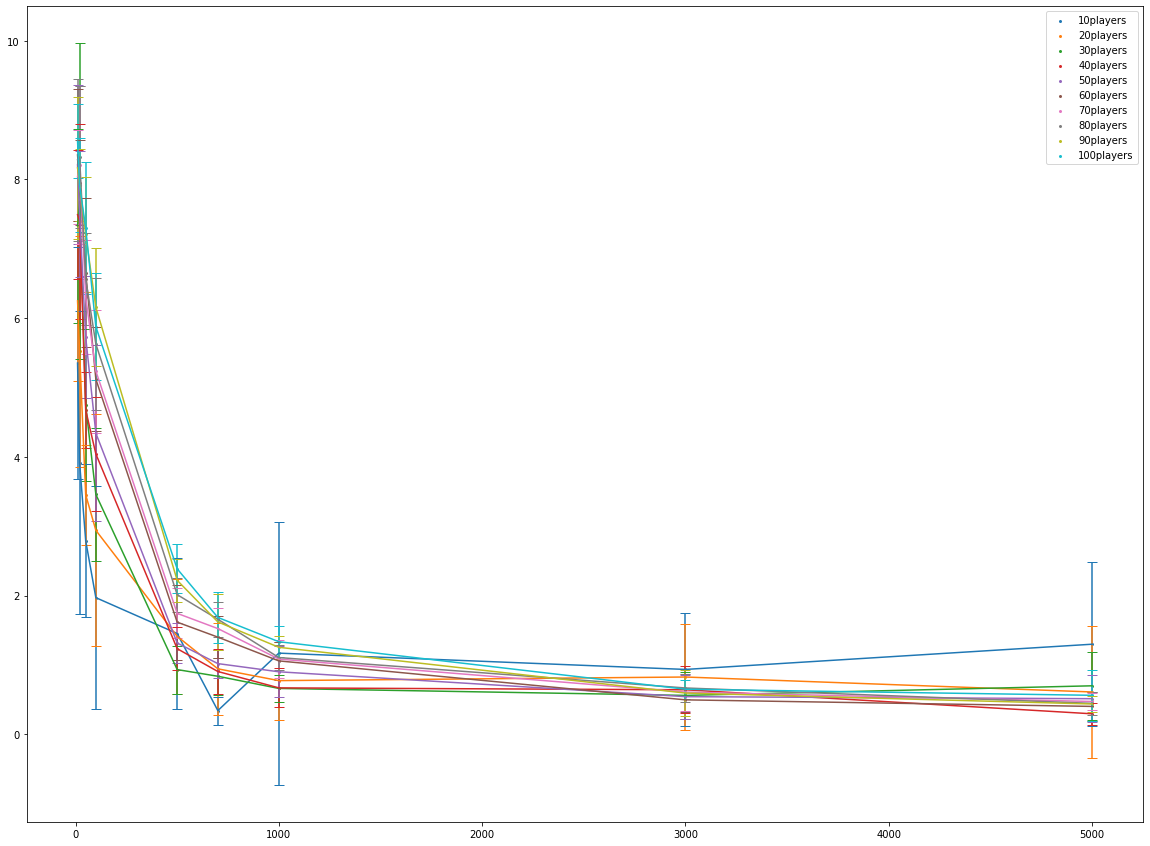

In [52]:
plot_result(result_skill_MSE_10_100[:10],[10,20,30,40,50,60,70,80,90,100,150,200,300,500][:10])

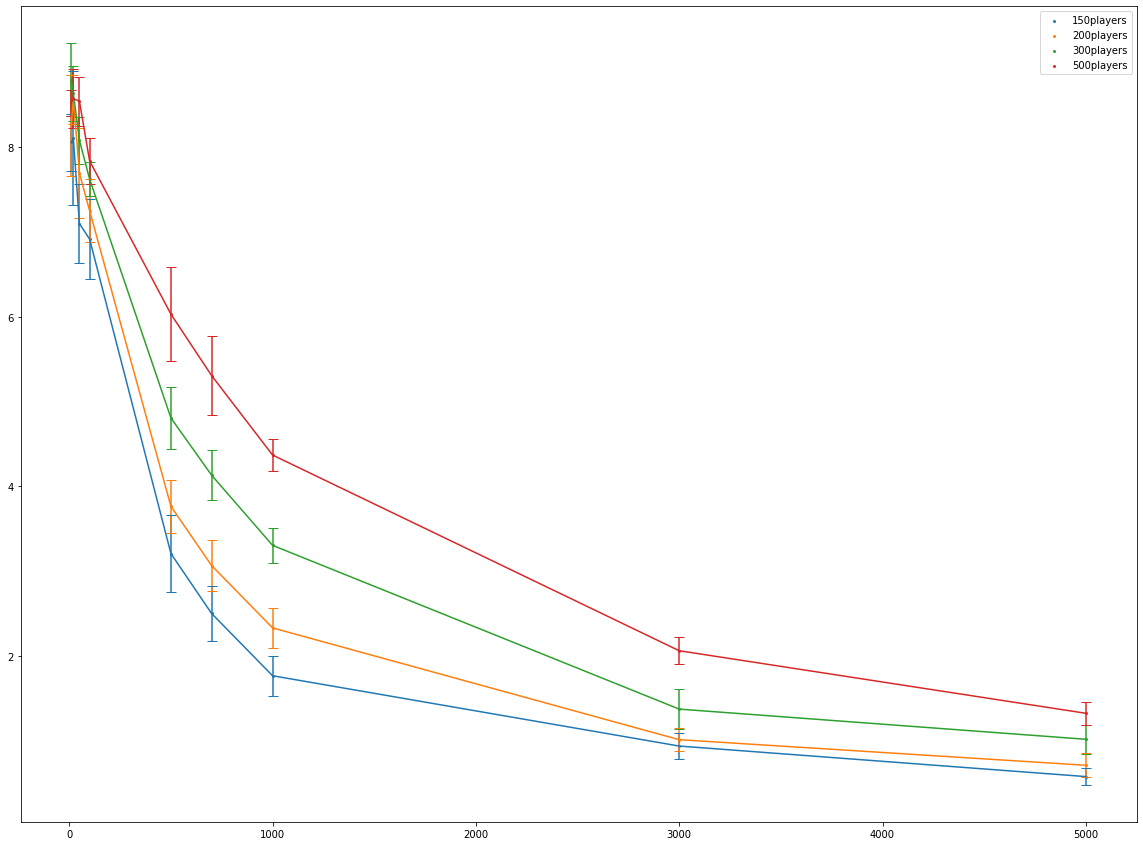

In [53]:
plot_result(result_skill_MSE_10_100[10:],[10,20,30,40,50,60,70,80,90,100,150,200,300,500][10:])

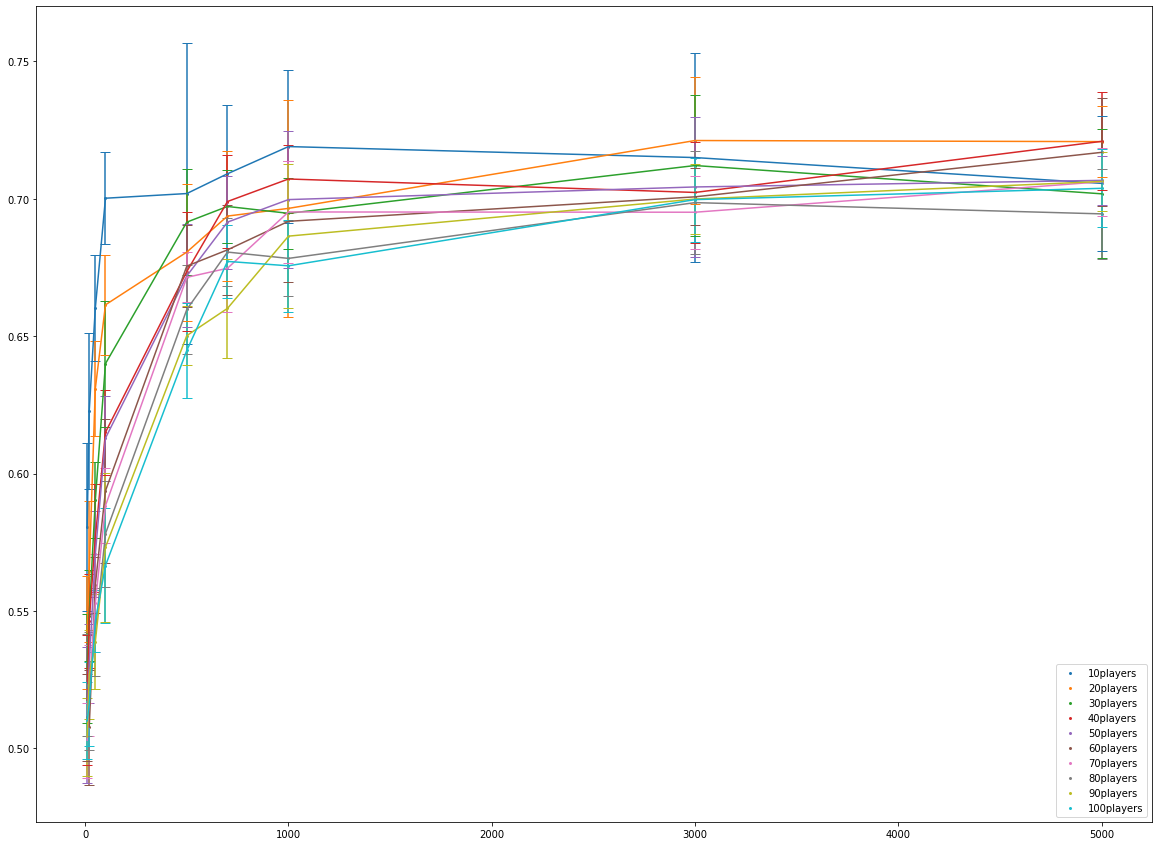

In [54]:
plot_result(result_prediction_10_100[:10],[10,20,30,40,50,60,70,80,90,100,150,200,300,500][:10])

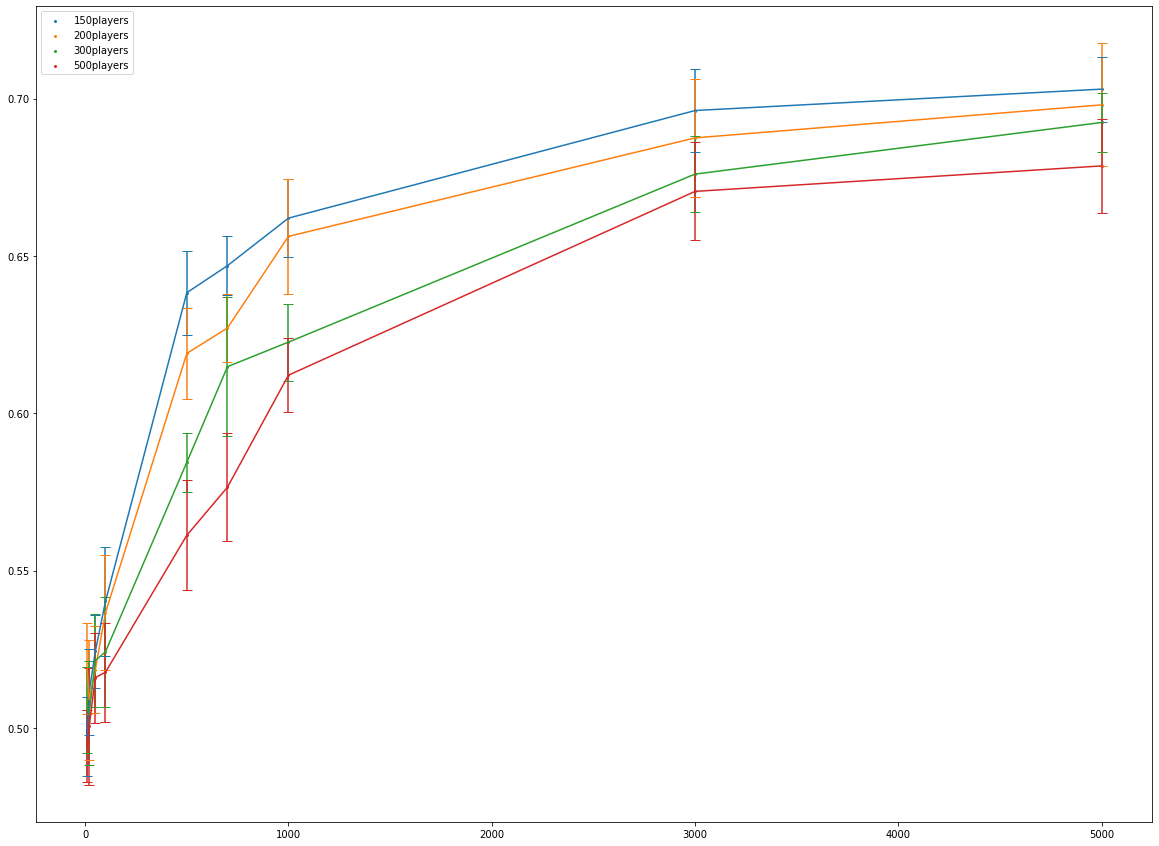

In [55]:
plot_result(result_prediction_10_100[10:],[10,20,30,40,50,60,70,80,90,100,150,200,300,500][10:])

Second test, test 100+ players

In [56]:
result_skill_MSE_100_1000=[]
result_prediction_100_1000=[]
for num_of_players in [100,125,150,175,200,300,500,700,1000]:
  starting_time=time.time()
  scale=0.5
  print("\n\nStarting num_of_players =",num_of_players)

  nplayers = num_of_players
  nlevels = 10   # let's say 10 discrete skill levels

  result_skill_MSE={}
  result_prediction={}
  print("num_of_games = ",end='')
  for num_of_games in [10,500,700,1000,3000,5000,7000,10000]:
      
      trials_result_skill=[]
      trials_result_prediction=[]
      print(num_of_games,end=',')
      for trials in range(10):
          true_players = generate_players(num_of_players,nlevels)
          train_games = generate_games(true_players, num_of_games, scale, style='pygm')

          # print("true skills:",true_players)

          # nplayers = max( [max(g[0],g[1]) for g in games] )+1 #number of players

          # Make variables for each player; value = skill level
          X = [None]*nplayers
          for i in range(nplayers):
              X[i] = gm.Var(i, nlevels)   

          # Information from each game: what does Pi winning over Pj tell us?
          #    Win probability  Pr[win | Xi-Xj]  depends on skill difference of players
          Pwin = np.zeros( (nlevels,nlevels) )
          for i in range(nlevels):
              for j in range(nlevels):
                  diff = i-j                   # find the advantage of Pi over Pj, then 
                  Pwin[i,j] = (1./(1+np.exp(-scale*diff)))  # Pwin = logistic of advantage

          # before any games, uniform belief over skill levels for each player:
          factors = [ gm.Factor([X[i]],1./nlevels) for i in range(nplayers) ]

          # Now add the information from each game:
          for g in train_games:
              P1,P2,win = g[0],g[1],g[2]
              if P1>P2: P1,P2,win=P2,P1,-win  # (need to make player IDs sorted...)
              factors.append(gm.Factor([X[P1],X[P2]], Pwin if win>0 else 1-Pwin) )


          starting=time.time()
          model = gm.GraphModel(factors)
          model.makeMinimal()  # merge any duplicate factors (e.g., repeated games)
          # print("spent:",round(time.time()-starting,3))


          if model.nvar < 0:       # for very small models, we can do brute force inference:
              jt = model.joint()
              jt /= jt.sum()       # normalize the distribution and marginalize the table
              bel = [jt.marginal([i]) for i in range(nplayers)] 

          else:                    # otherwise we need to use some approximate inference:
              from pyGM.messagepass import LBP, NMF
              #lnZ,bel = LBP(model, maxIter=10, verbose=False)   # loopy BP
              lnZ,bel = NMF(model, maxIter=10, verbose=False)  # Mean field


          predicted_players = [ bel[i].table.dot(np.arange(nlevels)) for i in range(nplayers)]

          trials_result_skill.append( skill_MSE(predicted_players,true_players) )
          trials_result_prediction.append( prediction_accuracy(bel, X, Pwin, true_players, num_valid_game=1000, scale=scale) )
      
      result_skill_MSE[num_of_games]=trials_result_skill
      result_prediction[num_of_games]=trials_result_prediction
  print()
  print("total time spent:",round(time.time()-starting_time,2))
  print(result_skill_MSE)
  print(result_prediction)
  result_skill_MSE_100_1000.append(result_skill_MSE)
  result_prediction_100_1000.append(result_prediction)



Starting num_of_players = 100
num_of_games = 10,500,700,1000,3000,5000,7000,10000,
total time spent: 1457.38
{10: [8.650818924738225, 7.330466241915762, 7.802628777796787, 8.642451207508003, 8.229028277881085, 7.5791826840402905, 9.45883006843722, 7.503419834906157, 8.655925462342175, 7.444549561340421], 500: [2.0027455092261657, 2.6936172838983157, 2.144645740355416, 3.4851685997931376, 2.4444263852445984, 2.141150303000807, 2.4999811423499123, 1.9450959784717137, 2.282440155248439, 2.308756034453253], 700: [1.635328621925471, 1.613634306625123, 1.0245262448449262, 1.991903223326745, 1.9727409373597218, 1.9840300934658128, 2.051248434650922, 2.2810533873772822, 2.0424884314575062, 1.7512444841564527], 1000: [1.2287852013916978, 1.6001403485020935, 1.4119894474672745, 1.40610855152517, 1.1329873505451338, 1.1007551769541868, 1.3822476201958351, 1.1492442071812483, 1.7921876229789564, 1.4748829023152137], 3000: [0.8787907620419834, 0.6904412718681832, 0.7102410061475762, 0.40131599495

In [0]:
result_skill_MSE_100_1000 = [{10: [8.650818924738225, 7.330466241915762, 7.802628777796787, 8.642451207508003, 8.229028277881085, 7.5791826840402905, 9.45883006843722, 7.503419834906157, 8.655925462342175, 7.444549561340421], 500: [2.0027455092261657, 2.6936172838983157, 2.144645740355416, 3.4851685997931376, 2.4444263852445984, 2.141150303000807, 2.4999811423499123, 1.9450959784717137, 2.282440155248439, 2.308756034453253], 700: [1.635328621925471, 1.613634306625123, 1.0245262448449262, 1.991903223326745, 1.9727409373597218, 1.9840300934658128, 2.051248434650922, 2.2810533873772822, 2.0424884314575062, 1.7512444841564527], 1000: [1.2287852013916978, 1.6001403485020935, 1.4119894474672745, 1.40610855152517, 1.1329873505451338, 1.1007551769541868, 1.3822476201958351, 1.1492442071812483, 1.7921876229789564, 1.4748829023152137], 3000: [0.8787907620419834, 0.6904412718681832, 0.7102410061475762, 0.40131599495333115, 0.7690607398856487, 0.9592802951251878, 0.6374139375228003, 0.7859446566746858, 1.152855013084706, 0.7275291404382662], 5000: [0.6176987398796145, 0.4657926498324019, 0.5115490217014759, 0.4240732294223745, 0.7757231587082594, 0.329387889047829, 0.2649775669264428, 0.31310622948767836, 0.6379217675023393, 0.3009045174574873], 7000: [0.2562767605996938, 0.3701359132532464, 0.8085018693562064, 0.3831759389132143, 0.34740956294452663, 0.30193303843553965, 0.37189457659119024, 0.3669088820637459, 0.39371888160406887, 0.683059199309879], 10000: [0.386877302360958, 0.4431743299156509, 1.6501144299767594, 0.2665758360654331, 0.4562383513611012, 0.7489895821231443, 0.5119331536630413, 0.3078459322591735, 0.44844591124780675, 0.1853816610388629]},
                             {10: [8.708835026109684, 9.155715793101201, 7.387334464841922, 8.949316144614112, 9.21942938646672, 8.169404688021368, 7.973203441163781, 8.324011301203031, 8.33669079397596, 6.973750105215475], 500: [2.7276637982429857, 2.440029632523945, 2.8167539547332208, 3.105771489972543, 2.681861099061012, 2.5345518825238766, 3.274874853039537, 3.11733542810517, 2.331481367731346, 3.029103991445742], 700: [2.1996530650301604, 2.251277766649569, 2.1784677340948053, 2.61117260705934, 1.9044156867686899, 2.492702910859904, 1.9920360667079622, 2.072773737342409, 2.0953347554915442, 2.6367594663360268], 1000: [1.406193868550838, 1.7131962113776682, 1.966095453517244, 2.07442000189876, 1.4208268303183798, 1.3115603676480458, 1.5005021952601532, 2.298272773786986, 1.8241660628969312, 1.6660814254229774], 3000: [0.8858886218740967, 0.884362477488862, 0.49384554047177726, 0.6628861051334849, 0.4918291734657714, 0.9816893367379997, 0.6229286931649101, 0.661056509976101, 0.5572217820385256, 0.5348617835254479], 5000: [0.3673341094546903, 0.6235398500260475, 0.42040080131750995, 0.34940718266141046, 0.4464254403633496, 0.6074931426788567, 0.669218269419818, 0.5462776071770757, 0.5093272779226566, 0.7928014305717775], 7000: [0.3071233656134279, 0.5860154332399476, 0.3762262597812495, 0.5563822063841437, 0.5849104631797255, 0.9306608062200402, 0.543536268522052, 0.28330575831325794, 0.46829924065940565, 0.9606163327542268], 10000: [0.39219445564412136, 0.3972203504458176, 0.3168169877359835, 0.6816948551644215, 0.4346492550877794, 0.38410042079278744, 0.20328839361456583, 0.5417156372414303, 0.24777579424230112, 0.5621571003998589]},
                             {10: [7.899629299163586, 8.226478149518414, 8.787502657249195, 8.701987329443222, 7.144019934691716, 8.010523164546106, 8.367786425896247, 8.491649725216226, 8.701428827158589, 10.332228416399927], 500: [3.711545303564065, 2.2676056029161127, 3.7336238192869664, 3.329311412951239, 3.3906749208906173, 2.6851612432226877, 3.131944719724924, 3.6028496485004857, 2.519727429017616, 2.995469760840638], 700: [2.2535961282957846, 2.049840748150996, 2.5596530190271265, 2.8828608810709255, 2.426676576387147, 3.6169245864010677, 2.8242514646091226, 2.4149300657727624, 2.215928510102174, 2.177991620911715], 1000: [1.9911409096843014, 1.472201050580634, 1.9081257666335523, 2.310891336279369, 1.844573492877769, 2.2555958812814136, 2.379176176916311, 1.6159090829991023, 2.0240885164665943, 2.03722096671474], 3000: [0.5022177059942967, 0.8248716562494968, 0.9434127235534413, 0.9020905875971418, 0.7464294575237715, 0.8476398973727111, 0.6507667696597723, 1.2007076591604768, 0.7437112760020355, 0.746249001127073], 5000: [0.49326092405381916, 0.6916498430355653, 0.4579216715500986, 0.8631983259196135, 0.48330942275785505, 0.6566128164070005, 0.6649621435066297, 0.5851837229202089, 0.6193583940948365, 0.573834060168208], 7000: [0.5260422909902447, 0.5111515159974697, 0.8000680756354588, 0.4678605544788709, 0.324923699702892, 0.42402537823614567, 0.5610381170186648, 0.2786237634509436, 0.35604378471955905, 0.41753586995915165], 10000: [0.3199524511361522, 0.3509508228169779, 0.4183113957698965, 0.4841834390160182, 0.5844979166415796, 0.3240953755565212, 0.5467962421999085, 0.5784890145286669, 0.39832457792198783, 0.24563399662039634]},
                             {10: [9.405877836935808, 8.497346929491332, 8.97327787765123, 8.54860608370329, 7.885364807238841, 8.123866136343652, 7.640727323847579, 7.54754564276707, 8.88965651596037, 7.44388689930892], 500: [3.7756132097426027, 3.415203533669458, 3.45682140195375, 3.7325587789896146, 3.5416138449904797, 3.633754782010276, 3.0008133040341467, 3.24565593686798, 3.4211069831722747, 3.4667300835925268], 700: [2.8390333610280765, 2.5877135260699147, 2.2924044378344903, 3.870424088070294, 2.4243790014140907, 3.23053466220364, 2.799550624440527, 3.0701233156736083, 2.466357290855836, 3.370781972025615], 1000: [2.049227492831996, 2.002742781986229, 1.8034420709860226, 1.7415218225845734, 2.296402754401723, 1.75053695731334, 1.9178190339787624, 2.3316493056199645, 2.4758200437793714, 2.0999722991718692], 3000: [0.9344395242037121, 1.573824989936468, 0.9516521448229006, 1.1625704706292146, 0.8466848719356264, 0.8793374350107612, 0.7573247257895315, 1.2568216613080465, 0.7812146918986543, 0.9510420461646606], 5000: [0.6614556139374644, 0.9560590238208168, 0.7432587419662374, 0.8315824781125405, 1.1232110517857299, 0.7964160465572648, 0.47203522125109904, 0.7735022589329994, 0.45683954561806633, 0.6840044200171258], 7000: [0.5319554725503998, 0.6507326475150588, 0.6162904065089418, 0.4470314334212906, 0.7203658740812373, 0.45827238469294457, 0.4416899480414114, 0.545280213447021, 0.4503049875255378, 0.572699691469002], 10000: [0.4569629620181798, 0.6215412347206286, 0.5823101115319836, 0.6404409298289484, 1.0456584935301791, 0.7698638221110095, 0.40761641138462307, 0.39117276142088947, 0.3782350690211671, 0.34998453894181786]},
                             {10: [8.190926600452416, 8.584358864489637, 8.202817416473808, 8.541470200993608, 8.832620703717982, 8.359392898716909, 8.643142482844851, 8.915914952790022, 8.818268936393219, 7.7649226448696425], 500: [4.4542632699934215, 3.1941515714275983, 4.751991313541967, 4.013889013638171, 3.4423693289586303, 3.4913089317263517, 2.9330855136188543, 3.6382174726495857, 3.907892456754452, 2.832681796816465], 700: [3.1882542190655467, 2.98570664900286, 2.6470685657794495, 3.132724622938264, 2.75440958678149, 3.2254394058024713, 2.994100220794758, 2.6410701275429047, 3.39422367079526, 3.0972736110644745], 1000: [2.5572457358835616, 2.598513237906973, 2.6665878243525922, 2.6842363684342705, 2.463920369956143, 2.402941838159582, 2.9144773671623865, 2.2817173160491317, 2.3550273094867546, 2.4990437534454886], 3000: [0.9649650561344889, 0.9173058329403869, 0.8441283295970206, 1.0001428613497014, 1.0776118769097498, 0.8790984647594438, 1.3302616425165568, 1.1505739925232783, 1.1631291253503593, 1.136408233694514], 5000: [0.6964658040433953, 0.8331267231415085, 1.0038959305617152, 0.7922188927077265, 0.8675662524805625, 0.8759922054315323, 0.5899352478821613, 0.7315059651924031, 1.1854584809487918, 0.7472254112760156], 7000: [0.44225920054571866, 0.6257797920840786, 0.38606842368627686, 0.4367417098869833, 0.9075467010365142, 0.48247115272953295, 0.6013622452040136, 0.44957880286838775, 0.5024923753885996, 0.5224548338295051], 10000: [0.41154416748378303, 0.4231661945198515, 0.3772969269796905, 0.6211691798180388, 0.5660627593464821, 0.47180631873217693, 0.6097524797294731, 0.40822109229810044, 0.45031513972570353, 0.9317506088032634]},
                             {10: [9.441972379075276, 8.398142741245149, 7.817528620948897, 8.029922233439793, 8.342039153486017, 8.330723560603138, 7.67440138063933, 7.850102475844763, 8.565382910297584, 8.092349751955345], 500: [4.601115673863032, 5.391112085520252, 5.0350361340101895, 5.141455995731392, 4.542920428074863, 4.975929497440012, 5.558620566929978, 5.026469996297369, 4.399782972607605, 5.030604094238721], 700: [4.623522850840678, 4.209267854596887, 3.729340312890119, 4.944227219645696, 3.747370792036123, 4.487699498546239, 4.285458495932556, 4.28726923775685, 3.841082527952589, 3.730272240456371], 1000: [3.4880765747231135, 3.3485733636910826, 2.9451176455541153, 3.232314637083671, 2.658769805050761, 2.9455113369586075, 3.3040171219538985, 3.3659422051184458, 2.947152617079861, 2.8129121180751278], 3000: [1.236462088138948, 1.2852140856321848, 1.7681380614104167, 1.2609372468822757, 1.4207520211847053, 1.3002564806230061, 1.439077920208605, 1.1934130030331342, 1.2878224739850574, 1.1918345499251597], 5000: [0.8303722256220629, 0.8246032195711205, 1.269534098693202, 0.9400688057566259, 1.0964998108265853, 0.9114252638079973, 1.069211743817753, 0.9471012528331936, 0.9629472314624468, 0.8643542399482894], 7000: [0.9946299064860007, 0.7853602147824549, 0.7384948143793356, 0.6996547256246262, 0.8055006848570566, 0.7548316500054093, 1.0578606102489652, 0.8467611530768838, 1.059756583964168, 0.7457896538199392], 10000: [0.5461671908471621, 0.566269252840792, 0.6728883116819872, 0.4281324387352267, 0.7158732856375294, 0.6645163067677836, 0.5448800401251079, 0.8033851557736279, 0.5281784795391532, 0.7358755455643438]},
                             {10: [8.122184395469967, 8.446338630631207, 8.698373710556357, 8.117942908105908, 8.540219262124596, 8.533466631743556, 8.44070910971247, 7.802486870222028, 7.882996395818366, 8.57323489593519], 500: [6.638909137923858, 6.315939194537403, 6.332980584230413, 6.076327129039369, 5.851490609041125, 5.912906796472732, 5.687814286234905, 6.176890561517862, 5.83972833256114, 6.00328230074215], 700: [5.037912532551865, 4.620910668606928, 5.216468584036971, 5.089097545908553, 4.984302502100636, 5.330479055312491, 5.146280915161311, 5.801167024718648, 5.10993725832237, 5.114239568373415], 1000: [4.544334625742878, 4.745861417179271, 4.588221407438756, 4.035416732557724, 3.815125246817162, 4.592131685091623, 4.155816034945877, 3.95168124917308, 4.233970469569233, 4.041827493577239], 3000: [2.058226244447916, 1.976954274947502, 2.151786146631658, 1.910444831987258, 2.3106389921024943, 1.9243808809251317, 2.1391478888920274, 2.165693282017561, 2.053104884683872, 2.125503936043], 5000: [1.3500179177323177, 1.2575384059599914, 1.3002915602010767, 1.3608835744575156, 1.3355322602333977, 1.6011718780014104, 1.2811384225766398, 1.3563295581704564, 1.210587558731342, 1.420085619987626], 7000: [1.0274615731608852, 1.1384091064871622, 1.0759324430456685, 1.1223997852867282, 1.3960419658924097, 1.0575759093052512, 1.185628159750505, 1.037874146905093, 1.0810703202702596, 0.9733095017228854], 10000: [1.0211024515438463, 0.8426677688968102, 0.780000773653146, 0.8402940761542966, 0.8542997997037652, 0.7754667521701241, 0.7504193882037774, 0.8578291375643545, 0.8294721855458397, 0.8795814465902584]},
                             {10: [8.215277859901096, 8.116869192344538, 9.088284616206414, 8.375656283812171, 8.744244998603504, 8.144210578840438, 8.1725076010335, 8.104186377632928, 8.657161230476493, 8.263044450543218], 500: [6.289672360447308, 6.917448312818123, 6.466636422281822, 6.58959954444448, 5.806839059016328, 6.822758945543894, 6.495482661325791, 6.498890072694802, 6.45424510684064, 6.830405876567016], 700: [6.1774146231680565, 5.767231478834151, 6.131448911287497, 6.2581186995850135, 5.789806675329325, 5.893607609991345, 5.728741032183046, 5.24587171529241, 6.3022368102076545, 5.916243953871766], 1000: [5.290045428099983, 5.368178023793459, 5.264726496539468, 5.108028435236349, 4.927471829857029, 5.626392723682729, 5.156311102539914, 5.097316563218393, 5.061174276232664, 5.206130871178725], 3000: [2.5189535127111986, 2.519975109249628, 2.8283876401046633, 2.4455559484276232, 2.450510949274692, 2.5201942228885983, 2.871631832413791, 3.1897084326346032, 2.6053353296670143, 2.7546458608651063], 5000: [1.8956807029702292, 1.9564812566901522, 1.932935533713409, 1.9396715237366187, 1.6304945885604278, 1.7927850626984771, 1.778673420341353, 1.6523773478965764, 1.6272000622966312, 1.7778893696580174], 7000: [1.5439150380392046, 1.3783789772263506, 1.3638126785207367, 1.4929344869679981, 1.482759071394534, 1.191256261690629, 1.3467070041550235, 1.4407905146343265, 1.4300845178674113, 1.3514274136082747], 10000: [0.9599357934057114, 1.2668291645765355, 1.0695470492342023, 1.3846723300539834, 1.1200691214599625, 1.0803969912499156, 1.0775435796775552, 1.1954447049425208, 1.1007994803593417, 1.1033484299239003]},
                             {10: [8.308550256472865, 8.221619860792947, 8.773912155097127, 9.248583757824404, 8.736323856842766, 8.75587344386466, 8.430507702668578, 8.689280215597773, 8.73181131443996, 8.551087747284969], 500: [6.673049100769624, 6.957633211247774, 7.332598811876264, 6.89073210489299, 7.169480926965355, 7.349089797987994, 7.359602792604907, 6.985428411079634, 7.124552064182893, 7.25208183038945], 700: [6.907163658052777, 6.257305544034821, 7.263656042856575, 6.606302293735257, 6.5230740699190655, 6.713321904596376, 6.7230442026459905, 6.868306534060833, 6.745989119051513, 6.854785512586897], 1000: [6.090725263593302, 5.580656536176878, 5.350685605935178, 6.359781463684953, 6.265842704215732, 5.839017007167408, 6.002750870593221, 6.273813198354772, 6.116345783360779, 5.594479149275957], 3000: [3.2948843095751057, 3.4121827494977564, 3.366306159824272, 3.393878276739419, 3.5483768957393886, 3.339842463060985, 3.451082130825731, 3.0847207810555766, 3.5283685958013837, 3.3115120217252456], 5000: [2.5371120709144868, 2.4131400602912243, 2.1840375671224233, 2.1829724817718166, 2.5369394331774986, 2.2722123641797776, 2.166184308639056, 2.345545301275143, 2.316862664879374, 2.5830389179471216], 7000: [1.8266195326875667, 1.696022145277707, 1.731833066699481, 1.7230011848304307, 1.9268261100139683, 1.6522735264174153, 1.918344153562265, 1.7732059198594072, 1.6857855381471234, 1.5434920684270876], 10000: [1.283961513498738, 1.2633680201524924, 1.5452776171175242, 1.686675703546877, 1.2057404118698065, 1.2499670533188245, 1.2229526685832501, 1.291952163912785, 1.5263854793021772, 1.370735582693028]}
]

result_prediction_100_1000 = [{10: [0.535, 0.501, 0.5, 0.525, 0.507, 0.515, 0.539, 0.494, 0.491, 0.518], 500: [0.666, 0.637, 0.68, 0.658, 0.641, 0.654, 0.657, 0.633, 0.633, 0.652], 700: [0.676, 0.655, 0.665, 0.663, 0.69, 0.665, 0.664, 0.655, 0.657, 0.664], 1000: [0.678, 0.674, 0.693, 0.69, 0.69, 0.693, 0.684, 0.67, 0.7, 0.668], 3000: [0.719, 0.698, 0.712, 0.729, 0.707, 0.689, 0.701, 0.729, 0.691, 0.708], 5000: [0.707, 0.731, 0.689, 0.702, 0.685, 0.704, 0.701, 0.699, 0.723, 0.716], 7000: [0.705, 0.715, 0.697, 0.73, 0.681, 0.71, 0.706, 0.72, 0.699, 0.717], 10000: [0.707, 0.694, 0.69, 0.689, 0.695, 0.69, 0.707, 0.711, 0.71, 0.686]},
                              {10: [0.487, 0.498, 0.527, 0.496, 0.531, 0.495, 0.499, 0.507, 0.515, 0.509], 500: [0.655, 0.669, 0.665, 0.646, 0.647, 0.65, 0.617, 0.643, 0.656, 0.629], 700: [0.672, 0.674, 0.645, 0.609, 0.66, 0.637, 0.696, 0.659, 0.667, 0.671], 1000: [0.676, 0.679, 0.637, 0.633, 0.717, 0.656, 0.65, 0.658, 0.664, 0.659], 3000: [0.696, 0.677, 0.666, 0.654, 0.702, 0.666, 0.682, 0.704, 0.699, 0.718], 5000: [0.718, 0.684, 0.684, 0.709, 0.717, 0.694, 0.72, 0.702, 0.712, 0.718], 7000: [0.711, 0.674, 0.715, 0.695, 0.689, 0.721, 0.706, 0.724, 0.694, 0.696], 10000: [0.702, 0.713, 0.7, 0.724, 0.679, 0.724, 0.701, 0.7, 0.714, 0.702]},
                              {10: [0.492, 0.516, 0.496, 0.495, 0.496, 0.495, 0.533, 0.48, 0.518, 0.53], 500: [0.614, 0.626, 0.622, 0.648, 0.635, 0.66, 0.66, 0.631, 0.612, 0.626], 700: [0.652, 0.674, 0.659, 0.653, 0.656, 0.663, 0.652, 0.64, 0.682, 0.639], 1000: [0.659, 0.65, 0.69, 0.663, 0.684, 0.664, 0.671, 0.644, 0.663, 0.628], 3000: [0.714, 0.665, 0.703, 0.701, 0.701, 0.706, 0.704, 0.7, 0.709, 0.682], 5000: [0.74, 0.715, 0.683, 0.715, 0.691, 0.683, 0.711, 0.728, 0.711, 0.698], 7000: [0.679, 0.709, 0.713, 0.723, 0.713, 0.688, 0.657, 0.725, 0.682, 0.708], 10000: [0.703, 0.7, 0.738, 0.738, 0.693, 0.682, 0.715, 0.692, 0.71, 0.705]},
                              {10: [0.492, 0.508, 0.523, 0.478, 0.516, 0.514, 0.509, 0.511, 0.495, 0.517], 500: [0.637, 0.619, 0.616, 0.634, 0.629, 0.621, 0.642, 0.626, 0.618, 0.627], 700: [0.642, 0.651, 0.634, 0.642, 0.629, 0.64, 0.652, 0.642, 0.652, 0.676], 1000: [0.679, 0.666, 0.675, 0.659, 0.651, 0.672, 0.666, 0.664, 0.646, 0.656], 3000: [0.712, 0.681, 0.687, 0.68, 0.711, 0.706, 0.706, 0.694, 0.694, 0.693], 5000: [0.667, 0.737, 0.695, 0.691, 0.726, 0.709, 0.678, 0.694, 0.722, 0.695], 7000: [0.695, 0.697, 0.707, 0.71, 0.725, 0.686, 0.697, 0.707, 0.709, 0.668], 10000: [0.693, 0.724, 0.7, 0.726, 0.712, 0.68, 0.705, 0.701, 0.71, 0.696]},
                              {10: [0.506, 0.523, 0.483, 0.51, 0.518, 0.498, 0.475, 0.491, 0.521, 0.513], 500: [0.602, 0.596, 0.6, 0.607, 0.636, 0.624, 0.67, 0.639, 0.624, 0.653], 700: [0.644, 0.638, 0.636, 0.623, 0.625, 0.607, 0.648, 0.648, 0.652, 0.636], 1000: [0.629, 0.63, 0.684, 0.663, 0.64, 0.645, 0.665, 0.646, 0.627, 0.641], 3000: [0.683, 0.688, 0.703, 0.694, 0.697, 0.705, 0.687, 0.686, 0.676, 0.685], 5000: [0.687, 0.715, 0.686, 0.688, 0.698, 0.67, 0.711, 0.703, 0.712, 0.702], 7000: [0.686, 0.699, 0.696, 0.719, 0.673, 0.672, 0.691, 0.664, 0.688, 0.703], 10000: [0.7, 0.72, 0.719, 0.7, 0.735, 0.701, 0.703, 0.713, 0.71, 0.699]},
                              {10: [0.505, 0.491, 0.499, 0.48, 0.513, 0.515, 0.509, 0.508, 0.527, 0.496], 500: [0.62, 0.585, 0.591, 0.582, 0.607, 0.588, 0.571, 0.583, 0.6, 0.579], 700: [0.61, 0.607, 0.634, 0.598, 0.63, 0.61, 0.594, 0.638, 0.617, 0.633], 1000: [0.631, 0.62, 0.642, 0.626, 0.618, 0.614, 0.626, 0.636, 0.639, 0.635], 3000: [0.675, 0.659, 0.663, 0.67, 0.697, 0.677, 0.664, 0.709, 0.68, 0.685], 5000: [0.703, 0.705, 0.677, 0.698, 0.679, 0.703, 0.679, 0.704, 0.664, 0.701], 7000: [0.706, 0.678, 0.699, 0.69, 0.679, 0.717, 0.682, 0.669, 0.73, 0.67], 10000: [0.696, 0.703, 0.676, 0.685, 0.691, 0.709, 0.697, 0.675, 0.717, 0.691]},
                              {10: [0.487, 0.516, 0.522, 0.534, 0.506, 0.527, 0.522, 0.486, 0.478, 0.483], 500: [0.573, 0.574, 0.569, 0.591, 0.533, 0.586, 0.59, 0.549, 0.59, 0.573], 700: [0.591, 0.582, 0.573, 0.578, 0.6, 0.609, 0.557, 0.585, 0.558, 0.584], 1000: [0.601, 0.587, 0.579, 0.577, 0.598, 0.634, 0.6, 0.575, 0.615, 0.632], 3000: [0.681, 0.655, 0.653, 0.676, 0.689, 0.701, 0.67, 0.682, 0.665, 0.673], 5000: [0.681, 0.676, 0.667, 0.672, 0.664, 0.678, 0.659, 0.683, 0.703, 0.727], 7000: [0.686, 0.692, 0.721, 0.712, 0.687, 0.693, 0.686, 0.676, 0.672, 0.696], 10000: [0.701, 0.673, 0.684, 0.697, 0.711, 0.689, 0.672, 0.702, 0.708, 0.674]},
                              {10: [0.501, 0.499, 0.495, 0.486, 0.504, 0.505, 0.539, 0.528, 0.49, 0.51], 500: [0.546, 0.571, 0.561, 0.537, 0.544, 0.535, 0.527, 0.555, 0.534, 0.551], 700: [0.573, 0.585, 0.554, 0.557, 0.597, 0.579, 0.571, 0.583, 0.553, 0.566], 1000: [0.589, 0.598, 0.591, 0.603, 0.577, 0.591, 0.609, 0.572, 0.586, 0.581], 3000: [0.64, 0.649, 0.661, 0.633, 0.631, 0.656, 0.636, 0.659, 0.642, 0.637], 5000: [0.661, 0.669, 0.662, 0.675, 0.651, 0.661, 0.663, 0.679, 0.675, 0.674], 7000: [0.678, 0.683, 0.688, 0.683, 0.665, 0.688, 0.703, 0.669, 0.682, 0.669], 10000: [0.683, 0.695, 0.68, 0.69, 0.698, 0.682, 0.709, 0.68, 0.702, 0.706]},
                              {10: [0.498, 0.465, 0.483, 0.478, 0.507, 0.46, 0.505, 0.485, 0.52, 0.488], 500: [0.548, 0.544, 0.525, 0.57, 0.535, 0.534, 0.549, 0.546, 0.527, 0.529], 700: [0.543, 0.556, 0.526, 0.548, 0.536, 0.563, 0.558, 0.569, 0.564, 0.54], 1000: [0.583, 0.579, 0.577, 0.553, 0.574, 0.569, 0.577, 0.547, 0.556, 0.555], 3000: [0.638, 0.614, 0.629, 0.614, 0.613, 0.626, 0.604, 0.629, 0.611, 0.645], 5000: [0.669, 0.627, 0.675, 0.639, 0.669, 0.625, 0.667, 0.662, 0.663, 0.647], 7000: [0.635, 0.676, 0.661, 0.67, 0.662, 0.645, 0.644, 0.674, 0.666, 0.657], 10000: [0.651, 0.667, 0.676, 0.659, 0.679, 0.701, 0.694, 0.672, 0.701, 0.687]}]

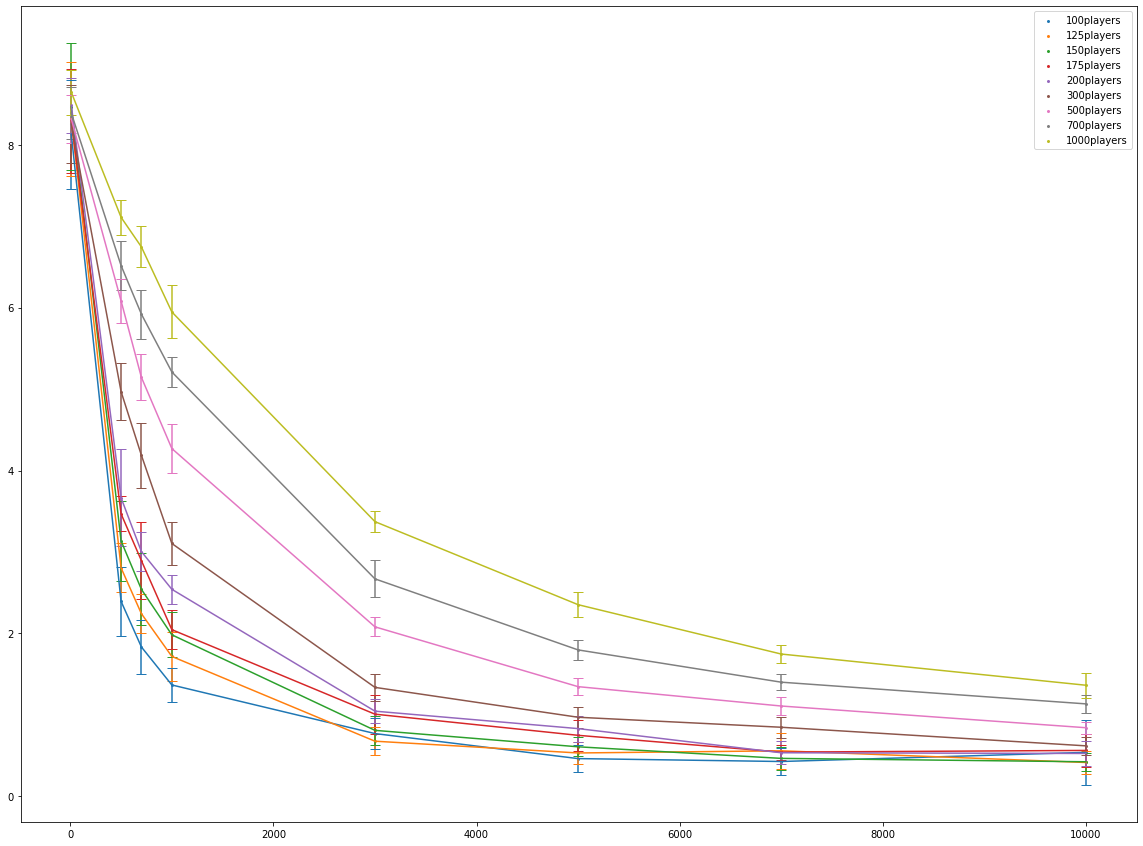

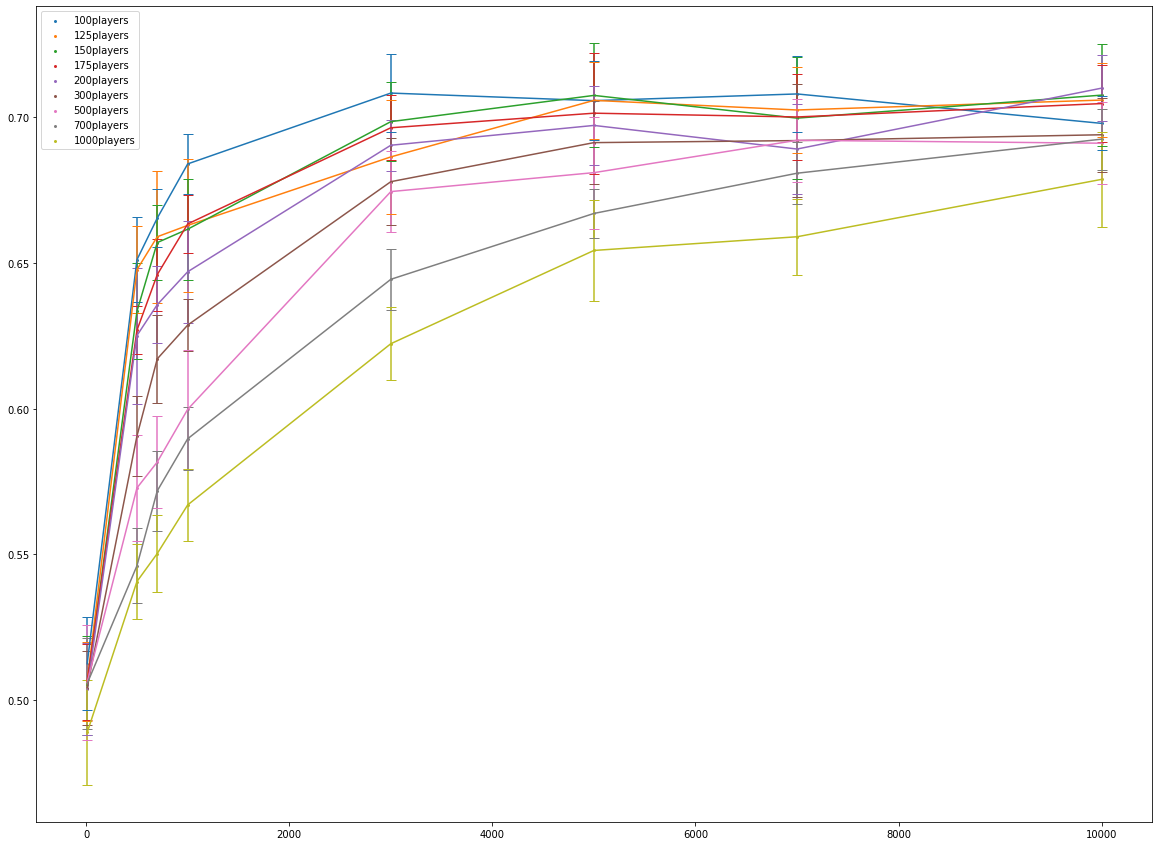

In [10]:
plot_result(result_skill_MSE_100_1000,[100,125,150,175,200,300,500,700,1000])
plot_result(result_prediction_100_1000,[100,125,150,175,200,300,500,700,1000])

In [7]:
result_skill_MSE_1000=[]
result_prediction_1000=[]
for num_of_players in [1000]:
  starting_time=time.time()
  scale=0.5
  print("\n\nStarting num_of_players =",num_of_players)

  nplayers = num_of_players
  nlevels = 10   # let's say 10 discrete skill levels

  result_skill_MSE={}
  result_prediction={}
  print("num_of_games = ",end='')
  for num_of_games in [5000,7000,10000, 12500, 15000, 17500, 20000]:
      
      trials_result_skill=[]
      trials_result_prediction=[]
      print(num_of_games,end=',')
      for trials in range(10):
          true_players = generate_players(num_of_players,nlevels)
          train_games = generate_games(true_players, num_of_games, scale, style='pygm')

          # print("true skills:",true_players)

          # nplayers = max( [max(g[0],g[1]) for g in games] )+1 #number of players

          # Make variables for each player; value = skill level
          X = [None]*nplayers
          for i in range(nplayers):
              X[i] = gm.Var(i, nlevels)   

          # Information from each game: what does Pi winning over Pj tell us?
          #    Win probability  Pr[win | Xi-Xj]  depends on skill difference of players
          Pwin = np.zeros( (nlevels,nlevels) )
          for i in range(nlevels):
              for j in range(nlevels):
                  diff = i-j                   # find the advantage of Pi over Pj, then 
                  Pwin[i,j] = (1./(1+np.exp(-scale*diff)))  # Pwin = logistic of advantage

          # before any games, uniform belief over skill levels for each player:
          factors = [ gm.Factor([X[i]],1./nlevels) for i in range(nplayers) ]

          # Now add the information from each game:
          for g in train_games:
              P1,P2,win = g[0],g[1],g[2]
              if P1>P2: P1,P2,win=P2,P1,-win  # (need to make player IDs sorted...)
              factors.append(gm.Factor([X[P1],X[P2]], Pwin if win>0 else 1-Pwin) )


          starting=time.time()
          model = gm.GraphModel(factors)
          model.makeMinimal()  # merge any duplicate factors (e.g., repeated games)
          # print("spent:",round(time.time()-starting,3))


          if model.nvar < 0:       # for very small models, we can do brute force inference:
              jt = model.joint()
              jt /= jt.sum()       # normalize the distribution and marginalize the table
              bel = [jt.marginal([i]) for i in range(nplayers)] 

          else:                    # otherwise we need to use some approximate inference:
              from pyGM.messagepass import LBP, NMF
              #lnZ,bel = LBP(model, maxIter=10, verbose=False)   # loopy BP
              lnZ,bel = NMF(model, maxIter=10, verbose=False)  # Mean field


          predicted_players = [ bel[i].table.dot(np.arange(nlevels)) for i in range(nplayers)]

          trials_result_skill.append( skill_MSE(predicted_players,true_players) )
          trials_result_prediction.append( prediction_accuracy(bel, X, Pwin, true_players, num_valid_game=1000, scale=scale) )
      
      result_skill_MSE[num_of_games]=trials_result_skill
      result_prediction[num_of_games]=trials_result_prediction
  print()
  print("total time spent:",round(time.time()-starting_time,2))
  print(result_skill_MSE)
  print(result_prediction)
  result_skill_MSE_1000.append(result_skill_MSE)
  result_prediction_1000.append(result_prediction)



Starting num_of_players = 1000
num_of_games = 5000,7000,10000,12500,15000,17500,20000,
total time spent: 5264.29
{5000: [2.2927082876587046, 2.519010041406983, 2.3313001174822507, 2.5097633810247437, 2.4706844248701834, 2.50240592503955, 2.4748421388215256, 2.3465136383026506, 2.382626300431319, 2.339256220734172], 7000: [1.8986470107870832, 1.8895124357274227, 1.8628588747753236, 2.060621383763476, 1.8686706870545637, 1.730157112040322, 2.036297803973123, 1.802988814882915, 1.7715706705483456, 1.8793892852628573], 10000: [1.3310422007651925, 1.5989315203443173, 1.339350080085487, 1.3681912686240156, 1.4047525549200104, 1.4729395144863044, 1.2641535437957223, 1.4699546961839798, 1.3801352796731043, 1.38951888003653], 12500: [1.2620921463793693, 1.072351615636761, 1.1339999748272955, 1.1133577071718805, 0.9728692879722439, 1.2019421337890828, 1.2430983725023432, 1.1107008559169442, 1.084985782617323, 1.0719662927543099], 15000: [0.9508974330017048, 0.9553796250788453, 1.21628303764045

In [36]:
import matplotlib.pyplot as plt
import numpy as np
def plot_result_skill_mse(result,num_of_players,pic_name):

    plt.figure(figsize=(10,5))
    for i,nplayers in enumerate(num_of_players):
        d = result[i]
        x = np.array([k for k in d])
        all_trials = np.array([d[k] for k in d])
        y = np.mean(all_trials, axis = 1)    
        std = np.std(all_trials, axis = 1)
    
        plt.scatter(x, y, marker='.' ,label = str(nplayers)+'players',linewidths=0.01)
        plt.errorbar(x, y, yerr = std, capsize = 5)
    plt.title("Skill MSE vs. number of games used")
    plt.ylabel("Mean Squared Error")
    plt.xlabel("number of games used")
#     plt.ylim(-1,9)
#     plt.xlim(-100,5000)
    plt.legend()
    plt.savefig(pic_name)
    plt.show()

def plot_result_prediction(result,num_of_players,pic_name):

    plt.figure(figsize=(10,5))
    for i,nplayers in enumerate(num_of_players):
        d = result[i]
        x = np.array([k for k in d])
        all_trials = np.array([d[k] for k in d])
        y = np.mean(all_trials, axis = 1)    
        std = np.std(all_trials, axis = 1)
    
        plt.scatter(x, y, marker='.' ,label = str(nplayers)+'players',linewidths=0.01)
        plt.errorbar(x, y, yerr = std, capsize = 5)
    plt.title("Prediction accuracy vs. number of games used")
    plt.ylabel("Prediction accuracy")
    plt.xlabel("number of games used")
#     plt.ylim(-1,9)
#     plt.xlim(-100,5000)
    plt.legend()
    plt.savefig(pic_name)
    plt.show()

In [24]:
result_skill_MSE_10_100 = [{10: [3.6601592820950293, 4.856499098141223, 5.96247309759182, 3.20344717324111, 7.701105977231956, 5.645569031303085, 8.085657621504659, 3.4907355057310943, 4.196992074248885, 6.717350296777528], 20: [3.9112149771943523, 2.1100254992323104, 3.252142509208047, 7.469542402708001, 8.098086593614864, 3.7074542254051535, 2.7577320959034193, 0.8118874845727724, 2.439469909909426, 4.615541008492641], 50: [2.6010536976817336, 3.8114305812438216, 2.934706469619792, 2.1196212646847736, 1.011452100190151, 3.07157901464542, 1.6188099750986276, 5.04554084324337, 3.505838043071436, 2.2023127366942954], 100: [0.6768174712828202, 3.901416618265485, 1.4149455932304666, 0.5957660849194895, 5.279676649775204, 1.4263973377978514, 0.5968386883312797, 1.8625413367509054, 3.554453989684439, 0.38242444951044524], 500: [3.516174402695049, 1.0133076020751315, 1.9371520689554422, 1.0598195957394805, 0.13446489463202166, 0.2307588071360005, 1.3083364532464918, 2.5316299731194265, 0.2313659772038618, 2.557782765099179], 700: [0.6674694919392918, 0.2948839777771118, 0.28636971888604096, 0.0978111930734448, 0.6597511922092012, 0.1423543731156714, 0.1274073509860125, 0.3371606936473356, 0.2410491650037176, 0.5531225402128838], 1000: [0.5654094997759748, 0.11951150746974881, 0.534847598193984, 0.16987897994259843, 1.3402410404980878, 0.21465255868504013, 0.4903259665818919, 6.726693073047203, 1.2791840501684404, 0.2516088764135659], 3000: [1.9874327766469093, 0.22981326092838034, 0.2290668032595216, 2.6273320011974572, 0.9254358375953602, 1.0554554502639941, 0.14090863650868862, 0.1590543246348376, 0.556915791711941, 1.4305271226617133], 5000: [1.2717474975813887, 1.5425501608810963, 0.697554865392638, 2.5582383036325647, 4.029230948422033, 0.05572911471537602, 0.5686391263694609, 0.39910292589007285, 0.10271030471397646, 1.7532587078077189]}, {10: [4.353468862735621, 5.6206512627828, 7.287884323087681, 6.273684592323887, 7.7071379408293055, 6.337455672452961, 6.2731615720753835, 6.764672799410784, 7.629078642093296, 4.24586217333148], 20: [7.526658550151531, 5.878071486215375, 6.011486762855052, 4.751778378062804, 4.251053108951064, 1.6872425208822261, 4.871130332825101, 7.7037275404371615, 6.080754796648013, 6.4600413344022725], 50: [4.304215988044472, 3.730764358029971, 3.92382263859134, 3.4829429519341515, 3.04882492402821, 2.085698811527092, 2.3628221878284736, 3.3882310506819993, 4.273666267347272, 3.934028712382412], 100: [1.983144153322844, 1.4659436513342166, 1.0023762570510921, 6.591389679829281, 3.1071991058631765, 2.8016698193401295, 4.759755906356304, 1.997520239416842, 1.5157451128293644, 4.176093001269857], 500: [2.253684214202452, 2.8516549678875838, 0.42710785693237785, 1.475117490890988, 1.0138367070065932, 1.2208274516533397, 2.4812546695557924, 1.4659397114645434, 0.4112915107213384, 0.5148750898823029], 700: [0.3581986238372603, 0.6929726703214028, 0.46379818914678916, 2.0608246007650948, 0.8757740072682239, 0.49929132468229226, 2.3146109575708347, 0.46030003456454616, 1.1104968092382663, 0.5938240241021436], 1000: [0.6684788398412714, 0.6739317251204623, 2.0423067377789224, 0.5121346952449768, 1.391857419821033, 0.21332743025243697, 1.2231456483172283, 0.3614149732724659, 0.34208831453258026, 0.3002833964800707], 3000: [0.11165585677815146, 1.185486808994868, 2.697329014084869, 0.9102466361420477, 0.7747768178247254, 0.4543556012794925, 0.29172778907175567, 1.4675651762842072, 0.2662279856143757, 0.08895642853947554], 5000: [0.0984762962190823, 0.5461275380739872, 0.2274026540340614, 0.5311375082566597, 0.150487659748082, 0.3587450982904338, 3.420919376171402, 0.12149025297131806, 0.17690739270544284, 0.4615437585766503]}, {10: [8.502673370806987, 10.516950474172413, 6.4006137525848255, 6.838197290755454, 5.965764651733613, 6.527473199206954, 7.0224479153606545, 5.653433756649926, 8.513600466605878, 7.359255724360684], 20: [5.132378149221868, 12.179729814902087, 7.438986603310669, 6.035637769116053, 6.586406733559348, 10.490612197634473, 9.279011394579026, 8.617278343342285, 6.104753844088777, 4.986999692852175], 50: [6.797088042752377, 4.434641204903211, 3.5281635431349097, 4.698102506590488, 4.145579979262276, 4.948402890510753, 3.7653438954646665, 3.3546259913728935, 5.560966970968223, 6.217872976179838], 100: [4.240696052644659, 2.7723387473499757, 2.8665698983039247, 3.833207919259417, 3.538406148709789, 4.516103568276427, 2.879995640211171, 1.498524358381664, 3.471757665869237, 4.9627828897219315], 500: [1.060267390499436, 0.7613840633667083, 0.5972787457631784, 1.1238135847721809, 0.890437442073901, 0.5237776783568623, 0.7263617718249606, 1.5074381252717821, 0.6037444106487719, 1.5262224185965372], 700: [0.5977056211041749, 1.1594186050799442, 1.03016101799233, 1.2674448639673246, 0.8078432007314554, 0.7595533893160658, 0.942279025879642, 0.46104017355538474, 0.9009390422289457, 0.4323729319932833], 1000: [0.7918094940677665, 0.4108557120097835, 0.5332568208274112, 0.33347355435909937, 0.8447418792914743, 0.6040543512959273, 0.8393706012325453, 0.9264970285099744, 0.8036073374511364, 0.5150639529624855], 3000: [0.9266654157491985, 1.1624870152813327, 1.0262064789298357, 0.20075881243318558, 0.29350950376371837, 0.49700246372798057, 0.4129291023569142, 0.30490512302269757, 0.5514227745163247, 0.22278349487115093], 5000: [0.4665483244983248, 0.6036836310153446, 0.6682626223054366, 0.5766660106674327, 0.10792100421378266, 1.6499169057415035, 0.28186395813847753, 0.22043945706859785, 0.9365961511574584, 1.4702242349414314]}, {10: [8.074930275232232, 6.292714394401574, 7.153031716846632, 7.926220108700896, 6.6720244373828494, 8.586106671282865, 8.80875603946689, 5.896859143011251, 8.150697423560862, 7.347890726581378], 20: [9.033151381763826, 9.694767164496792, 6.378244207974985, 8.952961467407604, 6.319447702194283, 4.818905207813821, 6.863885575694465, 6.974535338019548, 7.348024964877409, 7.604793199688172], 50: [4.724157940218738, 4.95440203152849, 4.798805879937824, 5.255104210519734, 4.777324540236609, 5.2117124064428175, 3.871528916872647, 4.517530542600609, 5.168211113011429, 3.4817706909149253], 100: [3.8653222175435493, 4.617218244129603, 4.008322373529312, 3.4712055588540167, 3.0351316702070235, 5.0961921881024645, 3.0811003923595695, 3.2722343650635928, 5.59089788277984, 4.378506954258321], 500: [1.9512527062925311, 1.52277338915547, 1.0953577647409456, 1.1730833619524892, 1.0087527695853353, 1.272674724246516, 1.0232817651561459, 1.438092195217621, 0.8135125192186029, 1.0370360069894557], 700: [0.8582800426569616, 0.6553920722926867, 0.699800363829408, 1.2148667646135853, 0.8217755550421769, 0.6112939832520582, 0.679492870671937, 0.7330885617726393, 1.0760427622105608, 1.6952371707763512], 1000: [0.6880297179305762, 0.6243897763065276, 0.4416572450016516, 0.8008417986197955, 1.4404620832476902, 0.3842745318420424, 0.6055033204321372, 0.5144312940061815, 0.5797134201161608, 0.6046861110276296], 3000: [0.385376433829528, 0.36404876315246326, 0.36237233301103744, 1.1683125771100746, 0.790235612222906, 0.2448626515917224, 0.8986504830568391, 0.7399614634301843, 1.1559576590118723, 0.29975296167224047], 5000: [0.1885459149569039, 0.1753474374581889, 0.492573358130059, 0.11039270748630711, 0.17490654984395132, 0.30833860425056836, 0.285451491717851, 0.1815657892120914, 0.6408546741960341, 0.3870114588485662]}, {10: [7.068343933573321, 7.146538263193435, 8.526174587840309, 8.754831606492926, 11.021655017996395, 8.553051945464867, 8.472343604809712, 6.754046724759722, 8.01121377946497, 7.824091494241792], 20: [7.054555297278691, 6.45003108663484, 7.5912747437733445, 7.648939618265358, 8.512364877284837, 7.678731099699735, 6.363415771501454, 6.9237790414099045, 7.247460892824096, 9.548732135239751], 50: [6.30082013225573, 4.357253431270827, 6.764416862600678, 5.488996108709816, 6.700329242866051, 5.353698366193596, 5.082590188488018, 7.084417965692739, 4.781470303218016, 5.3463288261384685], 100: [3.4331754998547437, 3.4136010829806365, 3.5692820509930114, 3.6702852707884723, 6.795896406330419, 3.2013037030420084, 5.306757732421072, 6.406761143482795, 4.138499664197843, 3.4744064848754035], 500: [0.998389200238573, 0.8703932049432391, 1.0188936972958647, 1.57186746445639, 1.477483926940436, 1.843921570070134, 1.4122885954780129, 1.4064451634476018, 1.1738921158985602, 1.381405310939484], 700: [1.2901404467781306, 0.8994204553651549, 0.793896876555147, 1.4485305541457045, 1.1018349579147826, 1.0685238260460723, 0.9664948581419887, 0.8725859449580269, 0.8999484819010921, 0.8413767745272875], 1000: [0.577656382416547, 0.7877272059735445, 0.8910315449738964, 0.8887356800096875, 1.4767542167252348, 1.6231060620289848, 0.5780153071732026, 1.0784383105326905, 0.5967639246404903, 0.5053882823937125], 3000: [0.291330682578865, 0.9073005458198891, 0.21505770505742602, 0.32839502834766376, 1.029728832196458, 0.2040642570695097, 0.5961579918097413, 1.0155521365357538, 0.2680840639066162, 0.5599004172021376], 5000: [0.8173038036423526, 0.28528894184401266, 0.19018037843940905, 0.17508261704179376, 0.31533728030499897, 0.6891339181727284, 0.5642865209581321, 1.2667619372576753, 0.15868837696266752, 0.6606152739307872]}, {10: [9.337826306950502, 7.147269240266341, 8.194571550125598, 9.485503350808868, 8.90219080608697, 9.71707094895326, 6.9313303304188185, 8.394773831981073, 8.096638512453541, 7.325515000438997], 20: [6.969938796764752, 9.399982191256141, 7.653933431972991, 7.511257868102163, 7.966934437983727, 8.487538530518894, 8.226798273974397, 7.841254525148879, 7.745825332956511, 7.7497972130251815], 50: [5.982106641397874, 6.948852322800752, 6.6908967238060875, 4.701446384593103, 6.1703630670377185, 6.366006648370893, 6.799888509673807, 7.916235275986156, 6.127622668634427, 8.864609535134266], 100: [5.1553814392899975, 5.363204029799376, 3.7685332706190935, 4.664996395970887, 6.246709468302784, 4.638615576393428, 4.9120795915333035, 4.854054572115988, 5.103918071881327, 6.493865904904502], 500: [1.4942409874045461, 1.0706222387115247, 1.5745299723495314, 1.2002490628003835, 2.244956626457614, 2.038731955367898, 1.6727857532711907, 1.1080068994611851, 2.7395931845722856, 1.0164102848125043], 700: [1.0164783801200834, 1.794316012101564, 1.8505948895218554, 1.2377258925850971, 1.0834316022997537, 1.2497735119842983, 1.8616439059059187, 1.4665729523788935, 1.2682699889966274, 1.1718106617569315], 1000: [0.8897556755905125, 0.7511465776432616, 1.0855769469821093, 0.7993714382798611, 1.42146494576917, 1.130630280249997, 1.494374760288799, 0.8131915857402398, 1.3903816371449957, 0.7982898945911805], 3000: [0.3862541532152871, 0.45914298146923666, 0.27956075131024793, 0.7294417042242493, 0.6320697364492125, 0.28885188217028185, 0.5239512570052981, 0.2878924453581056, 0.7724456874567965, 0.596078834929211], 5000: [0.4148966773816171, 0.17934840487324258, 0.1324464770987444, 0.5337653594820487, 0.19580106008750522, 0.555724107465871, 0.7412738006743997, 0.4169024581196212, 0.17457867896226284, 0.6664631157698319]}, {10: [7.8871641562013455, 8.234224552476679, 7.834253288925205, 8.706607494057577, 8.972449569610884, 6.615276937921072, 8.324957224777137, 7.439245205889539, 7.614916590958028, 8.774624195060616], 20: [8.053825167400163, 7.523341115828557, 6.731450401684427, 8.085501023364547, 8.037528019355337, 10.749147950092262, 8.601573342119085, 6.706999816813389, 9.43117846306228, 8.155811088752186], 50: [6.783152441675123, 5.31303096602393, 5.470552202567774, 6.98385286951283, 7.592642579352342, 5.340870116652108, 7.009671575031024, 5.661986817400783, 5.752947809687069, 7.112937047714362], 100: [4.307885316206143, 6.945585810361605, 4.790316583074352, 6.592103712455479, 5.491371903985788, 4.376184935961248, 4.796350964998289, 5.419041790832038, 4.240238860900103, 5.407112551209392], 500: [2.2131312165165906, 1.683462794193426, 1.9841057612459883, 1.5315298668318211, 1.4465021681464254, 1.7250390793156585, 1.6013678985143092, 2.2029846944591918, 2.0417973855266713, 0.9997896633053311], 700: [1.5891981022897175, 1.0911385449939535, 1.3317326292092388, 1.2324670133686, 1.6618544074901827, 1.9217373937468925, 1.268297364680796, 1.4781140992760895, 1.536826971509319, 2.1229008679812456], 1000: [1.2087139708330619, 1.5238816435613105, 1.241421754980728, 0.6554379247254795, 0.9870599309026707, 0.8195333218764219, 0.9136650252951782, 1.523100119900437, 1.0091579498764947, 0.9548971000389459], 3000: [0.5764796382129311, 0.7693784343006227, 1.2728447451101619, 0.40459002408380645, 0.4033062885393172, 0.39650988443490987, 0.4115785838583616, 0.3872388412708649, 0.7167338410606495, 0.7379053334717854], 5000: [0.3548506600744119, 0.6456925482705322, 0.4600995680716231, 0.35590233651276554, 0.3247303130852514, 0.5807161999254952, 0.3090321706844189, 0.5269226771813453, 0.600827050761965, 0.5611592308203258]}, {10: [7.279241257608328, 8.976656992320969, 9.183773756589956, 9.50642316545826, 8.19668742180097, 6.576644440326675, 7.178108139146252, 6.776431389293194, 9.756975961056918, 9.399465864722094], 20: [7.469246943632368, 7.832726180082412, 6.273406582628772, 9.424553291002667, 9.649108171141652, 8.747305961506505, 7.281597513427412, 9.128229413260103, 8.622977248656593, 8.79533931780155], 50: [6.066744138768659, 6.731383528098279, 6.446864470400411, 8.105438870844932, 5.748681622075582, 6.344976122827501, 6.496997866202703, 5.761301705180876, 7.099449530543789, 6.859239609575771], 100: [6.451382148243233, 4.898358957950451, 3.793284846732631, 7.209854400869331, 6.556379939205357, 4.696099838537923, 5.641321790038976, 6.1272593445546, 5.339822390847028, 5.560324122339695], 500: [1.975180512604568, 1.9417915447113745, 2.0085364669916475, 2.124621982975685, 2.638101749155166, 1.8100635392176898, 1.9523953321117653, 2.021254649566936, 2.0182888076628607, 1.6359296319281487], 700: [1.7304165507419405, 1.5840291272569864, 1.260256654903746, 1.4639405624032262, 1.8463765414372209, 1.9431372740790747, 2.057304378891225, 1.3264487529100148, 1.8185779685045091, 1.5458338137993362], 1000: [1.0312610352350176, 1.2551549844935102, 1.0649987526083227, 0.9013867247691637, 1.088319727082216, 0.8711942926255949, 1.1388789775333577, 1.5234410165172203, 0.9692128755981676, 1.2124064972861957], 3000: [0.36283687372596923, 0.6667506933124285, 1.1254470509800067, 0.5762591341712409, 0.5449950203128565, 0.5867763105063586, 0.5340766340480971, 0.6309838585795366, 0.7246058735347037, 0.9158141617626967], 5000: [0.6775709311642837, 0.4812820267724757, 0.4627285112243425, 0.2556491889771542, 0.40683012009536423, 0.20850342757682427, 0.5648621094477282, 0.19686261210800443, 0.6795199759165843, 0.5181156031308746]}, {10: [6.721102439369044, 9.490424396196468, 8.285106402090493, 7.7923653064899465, 7.836550135036497, 8.445056284266052, 10.131403324883038, 7.729535858086664, 8.541904789655831, 6.693215967823146], 20: [7.306968239784025, 7.474442077064875, 8.605426541488518, 7.456828174637457, 8.971395250009396, 7.955020410345422, 8.189882754484104, 7.746081802947206, 8.02108845664124, 7.496442547671278], 50: [8.473587091080892, 5.65082485589771, 7.348013268323122, 7.031890526197658, 6.382445818914178, 7.297958868247243, 7.48102993029483, 7.813583385195623, 8.202557456016287, 6.383821369315916], 100: [5.909672739037602, 5.660633479194518, 6.357613444857789, 5.40717083667802, 6.893686170390385, 6.509900060813323, 8.153885890932267, 5.442720619575268, 6.161720572533226, 5.067766737532348], 500: [2.042658205590994, 1.8623465709173164, 2.3330116801180045, 2.6465622434493907, 2.486484693868015, 2.2662079191331705, 1.8148601599854066, 2.7289018379129883, 2.0137106834842893, 1.9966607492429267], 700: [1.5514566790652702, 2.6071597689587254, 1.3000652219532434, 2.0800903099035937, 1.318822270968985, 1.3614515562028349, 1.555847990542991, 1.624030195028202, 1.2104472902755676, 1.5851481681290673], 1000: [1.6052363095043836, 1.4287867989558596, 1.1130390875681075, 1.1886766935992235, 1.1753442753587364, 1.2513713144298884, 0.9677171685225672, 1.2718861461322946, 1.3169446392724555, 1.2160229162342284], 3000: [0.46497015780851514, 0.35061611876900206, 0.35650687658967123, 0.5754663949377649, 0.3343741426771125, 0.4496559200300297, 1.2608785352159617, 0.3706068329922574, 0.5413244506944517, 1.230180172287205], 5000: [0.45950960519193385, 0.2678053273535254, 0.3440083042872201, 0.6181497559981415, 0.6338704323959117, 0.33911195127966315, 0.37473991230983644, 0.4502290036710368, 0.3704154692245983, 0.5004513324473427]}, {10: [8.106474414850647, 9.116027740707358, 8.972689220278774, 7.545318633470019, 8.844452020170705, 8.242432137724997, 8.40161993919702, 9.071888604937504, 8.041683125398361, 9.173803160515313], 20: [9.37632270802008, 7.278410638899269, 7.367499002416329, 7.549218202172733, 7.7354075722665065, 7.817832294229082, 8.87181072536742, 7.11019605446169, 8.064058963188181, 7.990326115033764], 50: [7.026522520156712, 6.943237491403478, 7.865816011642349, 6.738772823671139, 9.0418996296116, 7.792497995621386, 5.2503133328078455, 7.91449633536022, 7.631943701785653, 6.799455107139128], 100: [5.407859216506889, 4.778366141170324, 5.330757382040138, 5.700594723955739, 5.188354713977458, 5.997398740152443, 7.381998527445263, 6.051081634205467, 7.090932361143675, 5.837573432273512], 500: [2.390562951901301, 2.8691315006436127, 2.1265644876799765, 2.2520582361714414, 2.18818951198051, 1.9333770836785968, 2.7609785127853956, 2.6663106313473333, 1.8514225590477118, 2.8089694450925213], 700: [1.916395068402176, 1.2316693062970696, 1.7791305046604022, 1.2932290175894554, 1.894439747618194, 1.1986387509231777, 1.4992112503746426, 2.4736891979232025, 1.7014150706684168, 1.8537191896521277], 1000: [1.276236906305252, 1.2471926600948722, 1.8848626906461652, 1.390913769710555, 1.4890735843434662, 1.047437248249791, 1.1640507461979235, 1.4084540062536233, 1.1529486163013591, 1.2770521445085878], 3000: [0.9555456634527214, 0.5084227909783828, 0.5218485454521865, 0.7422201793212574, 0.5719773437738995, 0.7645212870524696, 0.5896108357828949, 0.5093593399131061, 0.7433258810981775, 0.5816875963502011], 5000: [0.2798388835226971, 0.6881794403971733, 0.2434700998064989, 0.40167285710887035, 0.639536480693259, 1.5834054865745009, 0.4104849174103348, 0.3252801079583359, 0.5056733652242653, 0.5345055994147806]}, {10: [8.5116313300255, 8.34303098716894, 7.560072180506293, 7.941136313317003, 7.812069224893486, 8.488463866284567, 8.345898682320037, 7.605496864434844, 7.941706476367555, 8.004367237033495], 20: [10.141992348641992, 8.088757876724975, 8.741619747143304, 7.93872434388963, 8.084557865612645, 7.651342551694222, 7.91846175120133, 7.556272592849279, 7.059594283293623, 7.8818560203705195], 50: [6.696849816276065, 6.650479662884509, 7.539139667731644, 7.646535429749994, 7.118621881218514, 7.620649844630437, 7.063540870926052, 6.7670973607301415, 7.616347095066755, 6.267585894861825], 100: [6.7730924133066015, 6.819933776627287, 6.6553318244722774, 6.45001489925035, 6.899378215559923, 7.572686989938849, 7.089648783103648, 7.072186006061783, 6.0687467518320375, 7.752169130230277], 500: [3.1608692442230577, 3.6708918325120976, 2.552705808966094, 2.605343368443104, 2.9860327814982166, 4.139897807070302, 2.9459000976050493, 3.1587677969263463, 3.4147781172013985, 3.439927718397312], 700: [2.1675780451828657, 2.706986485393632, 2.4658378166057915, 2.231700039081456, 3.2933427188103357, 2.174661912579242, 2.5089867664075376, 2.7585239514442614, 2.270813993394096, 2.43127590856317], 1000: [1.817274215660227, 2.089403053313908, 1.5746449001934633, 1.670644504025982, 1.3895103275273162, 1.9691245008635765, 1.5010403806373205, 1.6322613485956037, 2.083004357133668, 1.9393237714850404], 3000: [0.7624557196000281, 1.1890027065109345, 0.9127675208047956, 0.8161289810478333, 0.6911055567059334, 1.1857472083508307, 0.9325733033678777, 1.0178952206033365, 1.0121612929039459, 0.8562298190689076], 5000: [0.5948105013204057, 0.5696003167060986, 0.49236149882188707, 0.5471472994888138, 0.6101145154536821, 0.6911015459273527, 0.4143040384824754, 0.7149782232745194, 0.4604317718544137, 0.6806486985991872]}, {10: [7.066087297851429, 8.21257761093605, 8.313331009152488, 8.967419187524271, 8.612127262727721, 8.52078028422132, 7.490377438744622, 8.759378451057765, 8.858076141594477, 7.737944233134726], 20: [8.767383808653989, 8.53760868839999, 8.603445031102794, 8.723709314097729, 8.425524733380765, 8.209027703547603, 9.051061643291103, 8.924231158505597, 8.212243143422771, 8.184964690004923], 50: [7.147046452280323, 7.896806900243769, 8.03183089462867, 6.80048226384872, 8.069415655961192, 8.557311230677593, 8.064434640588297, 6.983810341827845, 7.642970411207191, 7.743668512034787], 100: [7.177483919761866, 7.142572469378771, 7.556269920024899, 6.580198347491956, 7.803238152735146, 6.8561130135167225, 7.802515124098554, 7.205640608842329, 7.0384212055308115, 7.34128874062668], 500: [3.7537469310444975, 3.5901718553409676, 3.866349651261308, 3.4029247169263317, 3.3474104958777384, 3.634930897173066, 3.93076290909726, 4.4374079975608804, 4.073146670675946, 3.6031567989444766], 700: [2.912509630228052, 2.8873003519985803, 3.4982507953923174, 3.036862032568527, 2.664837176037937, 3.436636005140201, 2.9005391736132826, 3.1807412741110754, 2.677436514169814, 3.470267729104032], 1000: [2.6650950934534046, 2.2031452572628423, 2.1146902580920797, 2.4402535267058365, 2.1898813707180205, 2.5714811066305208, 2.284893409860448, 2.301754574653871, 1.8824506646894423, 2.656158044136072], 3000: [1.0392697196693, 1.0533052865911077, 0.8136058195836752, 0.913375515278775, 1.2816489671246039, 0.8564177758672226, 1.086296729422874, 1.0617844526022173, 0.8792276500588316, 1.1422834123060122], 5000: [0.9344689513636851, 0.42139629422286967, 0.698373936498085, 0.7673802006098092, 0.5952594451242776, 0.6191394779820594, 0.6706570750391526, 0.8868998653466619, 0.8220394940874424, 0.6939801953399862]}, {10: [8.741082543087979, 8.645904816667114, 8.502999983222562, 8.335669676207356, 8.784300612662495, 9.585972590855881, 9.109896089576772, 8.81023509423576, 8.07876756129465, 9.332085630924254], 20: [8.662517856286199, 8.703601506187178, 9.17128763295453, 8.385411481255966, 8.394318465728464, 8.266641026202633, 8.981617604652618, 8.180310575682622, 8.575286529590445, 9.04340270496434], 50: [8.239684083539766, 8.101616393529696, 8.38202745392099, 8.31964849279154, 8.347407947323235, 8.18338896405064, 7.668339454401278, 7.519484172294142, 8.032717030637402, 8.000700797378075], 100: [7.823431399646275, 7.615711685594582, 7.167853632271381, 7.369131439056454, 7.642250784547103, 7.7963554046043315, 7.851696315957124, 7.783986772894515, 7.57291074287629, 7.614967444828726], 500: [5.2279298649623795, 5.049664525651883, 5.122525627135483, 4.467875493051345, 5.432042450226152, 4.2829340712433766, 4.655416528734379, 4.495338788932141, 4.524260225367261, 4.802271017426505], 700: [3.9952307099219464, 4.1538067400327465, 4.334563899764442, 4.543107711943906, 4.241755556994736, 4.283787176669341, 3.9153673642330924, 4.432518836638691, 3.928262888958517, 3.4895328226990294], 1000: [3.57871641882532, 3.333305766635234, 3.4449398910296174, 3.251659161814304, 3.593716216217233, 3.37618850215523, 3.2725804554982116, 3.172833815947158, 2.873909689452963, 3.1432784925434136], 3000: [1.041820583953898, 1.3241058124933336, 1.5167623587141685, 1.7594417347596099, 1.1068665962690887, 1.4854168963298355, 1.1565301022658239, 1.670251666085464, 1.4926383139882688, 1.179406218208581], 5000: [1.0649128854467298, 0.9561743305711828, 1.2030834291270671, 1.1724190013457814, 0.9713052180717435, 1.2485663516377519, 0.8460846761532784, 0.6826639459896297, 1.1432772175257386, 0.8856306774117874]}, {10: [8.585188386747529, 8.330414331444153, 8.42759654740139, 8.506596745226794, 8.853918027268856, 8.658590272699477, 8.518669142252499, 8.364056705485917, 8.62230030754146, 8.386122630502896], 20: [8.589753959555466, 8.674775768823084, 7.755830781546812, 8.725779575724834, 8.975610755895598, 8.68316971700084, 8.876573861978327, 8.190212998584443, 8.853320305288644, 8.395775965993893], 50: [8.347890672203098, 8.266472557297716, 8.169522431860106, 8.91355821036087, 8.664243416912548, 8.26159490676267, 8.701637002238602, 9.078608228167367, 8.660569789250017, 8.340828982059039], 100: [7.803284681316963, 7.908828098728396, 7.660930805331181, 7.266080354035749, 7.617997702043178, 8.016563629713723, 7.985124382987662, 8.25224463889823, 7.723422292024133, 8.147948525410218], 500: [5.397514378884082, 6.17575848330411, 5.3572389422523825, 6.002190897341475, 6.396165089014405, 7.009436837362556, 5.869665108111063, 5.169479162970059, 6.419454018364558, 6.507539739814482], 700: [5.0023403231129455, 5.840521256407291, 5.318109134812156, 5.558749344152331, 6.1447997989919365, 4.684274683108671, 5.105216149533296, 4.577391442833917, 5.440421598434771, 5.3911578374545535], 1000: [4.126900288318043, 4.153820978398742, 4.184229542894625, 4.555589167434056, 4.260124830667109, 4.310778019704683, 4.696739345091598, 4.53190006869173, 4.287880684283971, 4.584395758506499], 3000: [2.0767451280952067, 1.820511656244191, 2.2902095763987886, 1.8876005348458926, 2.2528485797358564, 2.1040187109365363, 1.980535018566029, 1.8876694903022773, 2.253026632862998, 2.063336804239392], 5000: [1.1921175489281641, 1.2611054096136376, 1.3303234733207716, 1.2802433475746577, 1.4661096105796672, 1.640510333502668, 1.168917206976445, 1.1813437119637138, 1.3537935804822192, 1.3659947405636899]}, {10: [8.215277859901096, 8.116869192344538, 9.088284616206414, 8.375656283812171, 8.744244998603504, 8.144210578840438, 8.1725076010335, 8.104186377632928, 8.657161230476493, 8.263044450543218], 500: [6.289672360447308, 6.917448312818123, 6.466636422281822, 6.58959954444448, 5.806839059016328, 6.822758945543894, 6.495482661325791, 6.498890072694802, 6.45424510684064, 6.830405876567016], 700: [6.1774146231680565, 5.767231478834151, 6.131448911287497, 6.2581186995850135, 5.789806675329325, 5.893607609991345, 5.728741032183046, 5.24587171529241, 6.3022368102076545, 5.916243953871766], 1000: [5.290045428099983, 5.368178023793459, 5.264726496539468, 5.108028435236349, 4.927471829857029, 5.626392723682729, 5.156311102539914, 5.097316563218393, 5.061174276232664, 5.206130871178725], 3000: [2.5189535127111986, 2.519975109249628, 2.8283876401046633, 2.4455559484276232, 2.450510949274692, 2.5201942228885983, 2.871631832413791, 3.1897084326346032, 2.6053353296670143, 2.7546458608651063], 5000: [1.8956807029702292, 1.9564812566901522, 1.932935533713409, 1.9396715237366187, 1.6304945885604278, 1.7927850626984771, 1.778673420341353, 1.6523773478965764, 1.6272000622966312, 1.7778893696580174], 7000: [1.5439150380392046, 1.3783789772263506, 1.3638126785207367, 1.4929344869679981, 1.482759071394534, 1.191256261690629, 1.3467070041550235, 1.4407905146343265, 1.4300845178674113, 1.3514274136082747], 10000: [0.9599357934057114, 1.2668291645765355, 1.0695470492342023, 1.3846723300539834, 1.1200691214599625, 1.0803969912499156, 1.0775435796775552, 1.1954447049425208, 1.1007994803593417, 1.1033484299239003]}, {10: [8.308550256472865, 8.221619860792947, 8.773912155097127, 9.248583757824404, 8.736323856842766, 8.75587344386466, 8.430507702668578, 8.689280215597773, 8.73181131443996, 8.551087747284969], 500: [6.673049100769624, 6.957633211247774, 7.332598811876264, 6.89073210489299, 7.169480926965355, 7.349089797987994, 7.359602792604907, 6.985428411079634, 7.124552064182893, 7.25208183038945], 700: [6.907163658052777, 6.257305544034821, 7.263656042856575, 6.606302293735257, 6.5230740699190655, 6.713321904596376, 6.7230442026459905, 6.868306534060833, 6.745989119051513, 6.854785512586897], 1000: [6.090725263593302, 5.580656536176878, 5.350685605935178, 6.359781463684953, 6.265842704215732, 5.839017007167408, 6.002750870593221, 6.273813198354772, 6.116345783360779, 5.594479149275957], 3000: [3.2948843095751057, 3.4121827494977564, 3.366306159824272, 3.393878276739419, 3.5483768957393886, 3.339842463060985, 3.451082130825731, 3.0847207810555766, 3.5283685958013837, 3.3115120217252456], 5000: [2.2927082876587046, 2.519010041406983, 2.3313001174822507, 2.5097633810247437, 2.4706844248701834, 2.50240592503955, 2.4748421388215256, 2.3465136383026506, 2.382626300431319, 2.339256220734172], 7000: [1.8986470107870832, 1.8895124357274227, 1.8628588747753236, 2.060621383763476, 1.8686706870545637, 1.730157112040322, 2.036297803973123, 1.802988814882915, 1.7715706705483456, 1.8793892852628573], 10000: [1.3310422007651925, 1.5989315203443173, 1.339350080085487, 1.3681912686240156, 1.4047525549200104, 1.4729395144863044, 1.2641535437957223, 1.4699546961839798, 1.3801352796731043, 1.38951888003653], 12500: [1.2620921463793693, 1.072351615636761, 1.1339999748272955, 1.1133577071718805, 0.9728692879722439, 1.2019421337890828, 1.2430983725023432, 1.1107008559169442, 1.084985782617323, 1.0719662927543099], 15000: [0.9508974330017048, 0.9553796250788453, 1.2162830376404523, 0.8510520933726576, 0.9383475714995871, 1.163208712698798, 1.107691835371444, 0.9532817352885159, 1.0897806379969552, 1.0329100436788903], 17500: [0.8899175538229407, 0.9769960193232557, 0.8772937390527455, 0.84801863488511, 0.9220464571624065, 0.9205935742317081, 0.8604602356385211, 0.9359503903978545, 0.8434780674372382, 0.9716886709219212], 20000: [0.8230710502708544, 0.9047179144830225, 0.8499564187577036, 0.7736095707681885, 0.7995211606146002, 0.8942530632319796, 0.9180671894972051, 0.7232727863441875, 0.8350314666910337, 0.9227621784248325]}]

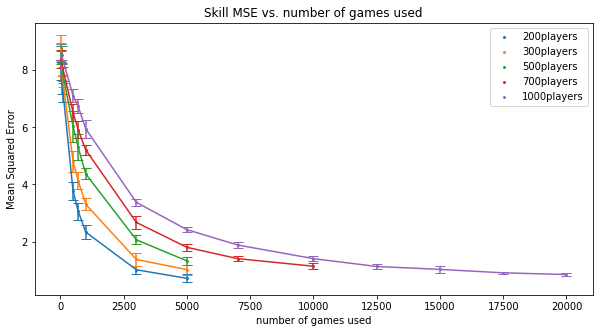

In [37]:
good_indices=[0,4,9,10,11]#,12,13,14,15]
good_indices = [11,12,13,14,15]
num_of_players_list = [10,20,30,40,50,60,70,80,90,100,150,200,300,500,700,1000]
plot_result_skill_mse([result_skill_MSE_10_100[i] for i in good_indices],[num_of_players_list[i] for i in good_indices],"Skill_MSE_200_1000" )

In [26]:
result_prediction_10_100 = [{10: [0.564, 0.581, 0.537, 0.61, 0.573, 0.605, 0.605, 0.581, 0.525, 0.625], 20: [0.643, 0.65, 0.647, 0.593, 0.589, 0.584, 0.605, 0.649, 0.605, 0.662], 50: [0.635, 0.664, 0.669, 0.685, 0.65, 0.648, 0.646, 0.634, 0.683, 0.688], 100: [0.714, 0.677, 0.708, 0.723, 0.681, 0.689, 0.706, 0.676, 0.714, 0.714], 500: [0.699, 0.696, 0.634, 0.738, 0.734, 0.764, 0.707, 0.747, 0.574, 0.726], 700: [0.695, 0.739, 0.698, 0.71, 0.683, 0.689, 0.689, 0.737, 0.759, 0.692], 1000: [0.743, 0.739, 0.712, 0.743, 0.714, 0.702, 0.754, 0.663, 0.685, 0.735], 3000: [0.752, 0.693, 0.665, 0.685, 0.773, 0.711, 0.731, 0.72, 0.762, 0.658], 5000: [0.648, 0.689, 0.745, 0.712, 0.705, 0.719, 0.715, 0.71, 0.69, 0.723]}, {10: [0.552, 0.554, 0.534, 0.553, 0.507, 0.54, 0.513, 0.546, 0.539, 0.583], 20: [0.533, 0.54, 0.534, 0.603, 0.564, 0.595, 0.595, 0.58, 0.545, 0.555], 50: [0.623, 0.641, 0.628, 0.648, 0.655, 0.637, 0.643, 0.606, 0.631, 0.597], 100: [0.684, 0.693, 0.65, 0.642, 0.647, 0.632, 0.658, 0.669, 0.668, 0.671], 500: [0.652, 0.636, 0.693, 0.677, 0.685, 0.723, 0.675, 0.66, 0.7, 0.705], 700: [0.695, 0.712, 0.656, 0.648, 0.724, 0.701, 0.683, 0.695, 0.716, 0.707], 1000: [0.694, 0.746, 0.677, 0.701, 0.726, 0.741, 0.645, 0.709, 0.712, 0.614], 3000: [0.701, 0.76, 0.697, 0.72, 0.702, 0.687, 0.753, 0.735, 0.723, 0.734], 5000: [0.703, 0.731, 0.723, 0.719, 0.712, 0.698, 0.72, 0.727, 0.741, 0.734]}, {10: [0.526, 0.551, 0.555, 0.519, 0.542, 0.506, 0.551, 0.494, 0.532, 0.513], 20: [0.541, 0.527, 0.59, 0.547, 0.538, 0.548, 0.544, 0.544, 0.564, 0.54], 50: [0.579, 0.609, 0.584, 0.611, 0.582, 0.602, 0.604, 0.579, 0.572, 0.581], 100: [0.652, 0.642, 0.653, 0.668, 0.59, 0.642, 0.668, 0.646, 0.62, 0.619], 500: [0.684, 0.725, 0.703, 0.679, 0.69, 0.722, 0.662, 0.672, 0.694, 0.684], 700: [0.708, 0.703, 0.711, 0.699, 0.704, 0.69, 0.706, 0.704, 0.668, 0.679], 1000: [0.691, 0.695, 0.697, 0.693, 0.678, 0.715, 0.701, 0.668, 0.707, 0.702], 3000: [0.705, 0.683, 0.658, 0.736, 0.719, 0.709, 0.741, 0.747, 0.72, 0.703], 5000: [0.718, 0.708, 0.654, 0.712, 0.675, 0.718, 0.716, 0.707, 0.733, 0.677]}, {10: [0.485, 0.572, 0.519, 0.509, 0.526, 0.535, 0.509, 0.527, 0.504, 0.489], 20: [0.525, 0.56, 0.559, 0.555, 0.549, 0.544, 0.555, 0.533, 0.512, 0.571], 50: [0.556, 0.561, 0.589, 0.606, 0.577, 0.56, 0.576, 0.56, 0.565, 0.615], 100: [0.635, 0.628, 0.63, 0.612, 0.593, 0.622, 0.61, 0.619, 0.583, 0.618], 500: [0.669, 0.683, 0.64, 0.663, 0.692, 0.648, 0.679, 0.653, 0.697, 0.711], 700: [0.702, 0.68, 0.665, 0.72, 0.693, 0.712, 0.693, 0.712, 0.693, 0.72], 1000: [0.707, 0.71, 0.72, 0.686, 0.701, 0.716, 0.7, 0.725, 0.718, 0.689], 3000: [0.686, 0.724, 0.706, 0.68, 0.734, 0.716, 0.716, 0.688, 0.693, 0.68], 5000: [0.734, 0.715, 0.739, 0.738, 0.731, 0.727, 0.723, 0.725, 0.682, 0.695]}, {10: [0.498, 0.516, 0.512, 0.577, 0.524, 0.482, 0.496, 0.491, 0.514, 0.511], 20: [0.517, 0.527, 0.54, 0.5, 0.53, 0.546, 0.537, 0.553, 0.536, 0.522], 50: [0.581, 0.578, 0.58, 0.561, 0.547, 0.572, 0.573, 0.54, 0.592, 0.582], 100: [0.63, 0.614, 0.618, 0.629, 0.588, 0.626, 0.626, 0.602, 0.586, 0.61], 500: [0.709, 0.663, 0.643, 0.664, 0.672, 0.659, 0.652, 0.683, 0.69, 0.684], 700: [0.693, 0.683, 0.69, 0.674, 0.733, 0.665, 0.692, 0.698, 0.694, 0.693], 1000: [0.678, 0.741, 0.733, 0.681, 0.671, 0.735, 0.696, 0.695, 0.682, 0.685], 3000: [0.665, 0.709, 0.663, 0.748, 0.703, 0.711, 0.731, 0.721, 0.703, 0.689], 5000: [0.712, 0.714, 0.712, 0.696, 0.718, 0.706, 0.714, 0.688, 0.702, 0.705]}, {10: [0.511, 0.517, 0.486, 0.503, 0.518, 0.512, 0.531, 0.482, 0.53, 0.523], 20: [0.486, 0.488, 0.485, 0.547, 0.523, 0.505, 0.524, 0.507, 0.527, 0.484], 50: [0.568, 0.574, 0.544, 0.561, 0.561, 0.554, 0.54, 0.564, 0.568, 0.561], 100: [0.556, 0.55, 0.584, 0.624, 0.612, 0.626, 0.616, 0.605, 0.57, 0.594], 500: [0.668, 0.691, 0.674, 0.682, 0.69, 0.699, 0.672, 0.646, 0.674, 0.659], 700: [0.679, 0.677, 0.697, 0.709, 0.663, 0.654, 0.666, 0.686, 0.699, 0.684], 1000: [0.677, 0.693, 0.675, 0.718, 0.67, 0.694, 0.667, 0.695, 0.742, 0.687], 3000: [0.695, 0.686, 0.692, 0.713, 0.715, 0.701, 0.686, 0.701, 0.714, 0.704], 5000: [0.678, 0.721, 0.713, 0.723, 0.733, 0.715, 0.704, 0.737, 0.696, 0.749]}, {10: [0.51, 0.487, 0.5, 0.533, 0.501, 0.502, 0.479, 0.509, 0.501, 0.507], 20: [0.53, 0.519, 0.518, 0.546, 0.528, 0.53, 0.522, 0.533, 0.489, 0.494], 50: [0.519, 0.534, 0.545, 0.563, 0.567, 0.58, 0.552, 0.541, 0.573, 0.554], 100: [0.599, 0.583, 0.581, 0.561, 0.6, 0.589, 0.596, 0.57, 0.606, 0.598], 500: [0.669, 0.67, 0.661, 0.685, 0.667, 0.66, 0.681, 0.662, 0.674, 0.685], 700: [0.686, 0.665, 0.676, 0.71, 0.661, 0.666, 0.688, 0.665, 0.653, 0.677], 1000: [0.683, 0.662, 0.699, 0.681, 0.697, 0.719, 0.693, 0.685, 0.703, 0.73], 3000: [0.704, 0.675, 0.699, 0.702, 0.695, 0.71, 0.705, 0.708, 0.682, 0.671], 5000: [0.727, 0.708, 0.709, 0.697, 0.709, 0.713, 0.723, 0.698, 0.69, 0.688]}, {10: [0.523, 0.498, 0.504, 0.512, 0.519, 0.566, 0.522, 0.539, 0.535, 0.513], 20: [0.539, 0.545, 0.495, 0.521, 0.505, 0.519, 0.551, 0.508, 0.541, 0.485], 50: [0.528, 0.54, 0.555, 0.549, 0.553, 0.542, 0.505, 0.546, 0.567, 0.539], 100: [0.599, 0.588, 0.613, 0.553, 0.559, 0.558, 0.583, 0.557, 0.584, 0.587], 500: [0.652, 0.664, 0.645, 0.671, 0.667, 0.658, 0.658, 0.635, 0.65, 0.697], 700: [0.661, 0.692, 0.677, 0.693, 0.657, 0.676, 0.685, 0.695, 0.688, 0.682], 1000: [0.671, 0.654, 0.695, 0.662, 0.683, 0.677, 0.674, 0.703, 0.686, 0.678], 3000: [0.697, 0.733, 0.675, 0.702, 0.675, 0.725, 0.693, 0.711, 0.695, 0.68], 5000: [0.724, 0.686, 0.679, 0.715, 0.692, 0.699, 0.665, 0.703, 0.696, 0.686]}, {10: [0.504, 0.5, 0.474, 0.509, 0.516, 0.508, 0.522, 0.492, 0.494, 0.522], 20: [0.509, 0.541, 0.514, 0.507, 0.552, 0.529, 0.538, 0.548, 0.519, 0.511], 50: [0.522, 0.565, 0.547, 0.546, 0.551, 0.54, 0.543, 0.54, 0.537, 0.497], 100: [0.531, 0.615, 0.556, 0.576, 0.553, 0.56, 0.595, 0.545, 0.591, 0.61], 500: [0.652, 0.648, 0.654, 0.668, 0.664, 0.636, 0.635, 0.659, 0.639, 0.647], 700: [0.66, 0.636, 0.651, 0.666, 0.689, 0.665, 0.688, 0.651, 0.631, 0.664], 1000: [0.681, 0.69, 0.704, 0.69, 0.668, 0.714, 0.696, 0.618, 0.712, 0.691], 3000: [0.677, 0.727, 0.699, 0.698, 0.707, 0.699, 0.701, 0.692, 0.71, 0.689], 5000: [0.714, 0.707, 0.705, 0.708, 0.705, 0.698, 0.73, 0.686, 0.707, 0.703]}, {10: [0.51, 0.521, 0.521, 0.493, 0.523, 0.487, 0.528, 0.494, 0.52, 0.503], 20: [0.511, 0.496, 0.503, 0.539, 0.538, 0.514, 0.508, 0.532, 0.522, 0.497], 50: [0.57, 0.537, 0.554, 0.532, 0.546, 0.534, 0.548, 0.545, 0.538, 0.558], 100: [0.572, 0.623, 0.564, 0.565, 0.563, 0.564, 0.555, 0.545, 0.57, 0.544], 500: [0.672, 0.622, 0.628, 0.652, 0.645, 0.654, 0.627, 0.674, 0.636, 0.638], 700: [0.698, 0.69, 0.657, 0.658, 0.688, 0.671, 0.668, 0.687, 0.672, 0.683], 1000: [0.675, 0.692, 0.636, 0.669, 0.665, 0.682, 0.671, 0.676, 0.699, 0.691], 3000: [0.713, 0.678, 0.681, 0.714, 0.716, 0.688, 0.719, 0.692, 0.71, 0.686], 5000: [0.709, 0.706, 0.714, 0.694, 0.701, 0.685, 0.729, 0.713, 0.709, 0.678]}, {10: [0.497, 0.5, 0.489, 0.521, 0.473, 0.503, 0.506, 0.506, 0.487, 0.491], 20: [0.499, 0.52, 0.513, 0.482, 0.521, 0.534, 0.501, 0.513, 0.517, 0.515], 50: [0.523, 0.501, 0.528, 0.538, 0.53, 0.531, 0.52, 0.542, 0.518, 0.512], 100: [0.514, 0.542, 0.559, 0.553, 0.524, 0.513, 0.555, 0.562, 0.532, 0.548], 500: [0.645, 0.641, 0.636, 0.614, 0.657, 0.616, 0.653, 0.647, 0.638, 0.636], 700: [0.651, 0.634, 0.647, 0.628, 0.658, 0.646, 0.656, 0.653, 0.641, 0.655], 1000: [0.653, 0.649, 0.671, 0.668, 0.673, 0.666, 0.64, 0.665, 0.683, 0.652], 3000: [0.692, 0.688, 0.719, 0.674, 0.701, 0.702, 0.695, 0.704, 0.71, 0.677], 5000: [0.694, 0.696, 0.695, 0.714, 0.723, 0.696, 0.716, 0.698, 0.705, 0.693]}, {10: [0.499, 0.514, 0.553, 0.52, 0.509, 0.516, 0.52, 0.511, 0.536, 0.511], 20: [0.539, 0.526, 0.51, 0.488, 0.483, 0.54, 0.507, 0.499, 0.505, 0.493], 50: [0.526, 0.534, 0.501, 0.525, 0.494, 0.506, 0.511, 0.522, 0.537, 0.529], 100: [0.565, 0.53, 0.514, 0.52, 0.565, 0.534, 0.552, 0.534, 0.54, 0.512], 500: [0.593, 0.605, 0.625, 0.621, 0.643, 0.619, 0.618, 0.612, 0.613, 0.641], 700: [0.615, 0.631, 0.633, 0.625, 0.638, 0.621, 0.649, 0.615, 0.63, 0.614], 1000: [0.65, 0.65, 0.645, 0.663, 0.646, 0.673, 0.649, 0.645, 0.703, 0.638], 3000: [0.703, 0.689, 0.664, 0.721, 0.658, 0.698, 0.695, 0.667, 0.681, 0.699], 5000: [0.694, 0.691, 0.726, 0.69, 0.724, 0.719, 0.668, 0.672, 0.708, 0.688]}, {10: [0.502, 0.516, 0.484, 0.494, 0.492, 0.517, 0.512, 0.508, 0.533, 0.499], 20: [0.485, 0.524, 0.507, 0.506, 0.478, 0.486, 0.517, 0.532, 0.507, 0.506], 50: [0.534, 0.505, 0.529, 0.541, 0.507, 0.537, 0.52, 0.516, 0.531, 0.494], 100: [0.514, 0.524, 0.539, 0.558, 0.541, 0.512, 0.495, 0.518, 0.509, 0.532], 500: [0.577, 0.597, 0.573, 0.584, 0.575, 0.596, 0.597, 0.587, 0.573, 0.585], 700: [0.609, 0.623, 0.597, 0.593, 0.611, 0.594, 0.646, 0.65, 0.638, 0.587], 1000: [0.608, 0.618, 0.644, 0.632, 0.622, 0.624, 0.633, 0.607, 0.606, 0.632], 3000: [0.673, 0.691, 0.656, 0.664, 0.681, 0.691, 0.669, 0.675, 0.693, 0.667], 5000: [0.676, 0.688, 0.704, 0.697, 0.697, 0.678, 0.705, 0.689, 0.691, 0.699]}, {10: [0.488, 0.518, 0.499, 0.508, 0.48, 0.498, 0.486, 0.493, 0.481, 0.491], 20: [0.543, 0.488, 0.477, 0.479, 0.514, 0.494, 0.508, 0.511, 0.492, 0.499], 50: [0.513, 0.525, 0.504, 0.538, 0.514, 0.517, 0.519, 0.486, 0.535, 0.509], 100: [0.494, 0.493, 0.498, 0.531, 0.524, 0.523, 0.526, 0.539, 0.519, 0.53], 500: [0.577, 0.548, 0.573, 0.585, 0.566, 0.548, 0.532, 0.561, 0.582, 0.54], 700: [0.587, 0.574, 0.61, 0.552, 0.568, 0.601, 0.577, 0.563, 0.563, 0.57], 1000: [0.613, 0.586, 0.606, 0.63, 0.611, 0.613, 0.601, 0.624, 0.619, 0.618], 3000: [0.685, 0.678, 0.671, 0.686, 0.652, 0.64, 0.657, 0.666, 0.689, 0.681], 5000: [0.693, 0.647, 0.668, 0.691, 0.682, 0.686, 0.695, 0.663, 0.671, 0.69]}, {10: [0.501, 0.499, 0.495, 0.486, 0.504, 0.505, 0.539, 0.528, 0.49, 0.51], 500: [0.546, 0.571, 0.561, 0.537, 0.544, 0.535, 0.527, 0.555, 0.534, 0.551], 700: [0.573, 0.585, 0.554, 0.557, 0.597, 0.579, 0.571, 0.583, 0.553, 0.566], 1000: [0.589, 0.598, 0.591, 0.603, 0.577, 0.591, 0.609, 0.572, 0.586, 0.581], 3000: [0.64, 0.649, 0.661, 0.633, 0.631, 0.656, 0.636, 0.659, 0.642, 0.637], 5000: [0.661, 0.669, 0.662, 0.675, 0.651, 0.661, 0.663, 0.679, 0.675, 0.674], 7000: [0.678, 0.683, 0.688, 0.683, 0.665, 0.688, 0.703, 0.669, 0.682, 0.669], 10000: [0.683, 0.695, 0.68, 0.69, 0.698, 0.682, 0.709, 0.68, 0.702, 0.706]}, {10: [0.498, 0.465, 0.483, 0.478, 0.507, 0.46, 0.505, 0.485, 0.52, 0.488], 500: [0.548, 0.544, 0.525, 0.57, 0.535, 0.534, 0.549, 0.546, 0.527, 0.529], 700: [0.543, 0.556, 0.526, 0.548, 0.536, 0.563, 0.558, 0.569, 0.564, 0.54], 1000: [0.583, 0.579, 0.577, 0.553, 0.574, 0.569, 0.577, 0.547, 0.556, 0.555], 3000: [0.638, 0.614, 0.629, 0.614, 0.613, 0.626, 0.604, 0.629, 0.611, 0.645], 5000: [0.633, 0.662, 0.663, 0.658, 0.659, 0.665, 0.666, 0.659, 0.657, 0.673], 7000: [0.684, 0.678, 0.637, 0.664, 0.689, 0.672, 0.669, 0.652, 0.66, 0.659], 10000: [0.661, 0.694, 0.685, 0.696, 0.681, 0.672, 0.668, 0.685, 0.69, 0.657], 12500: [0.692, 0.685, 0.666, 0.668, 0.687, 0.678, 0.715, 0.699, 0.686, 0.665], 15000: [0.705, 0.697, 0.687, 0.705, 0.654, 0.687, 0.706, 0.692, 0.666, 0.707], 17500: [0.663, 0.689, 0.675, 0.703, 0.71, 0.668, 0.709, 0.704, 0.703, 0.669], 20000: [0.7, 0.745, 0.683, 0.675, 0.71, 0.675, 0.696, 0.686, 0.697, 0.692]}]

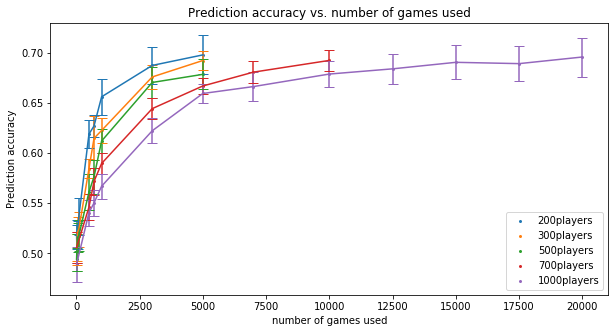

In [38]:
good_indices=[0,4,9,10,11]#,12,13,14,15]
good_indices = [11,12,13,14,15]
num_of_players_list = [10,20,30,40,50,60,70,80,90,100,150,200,300,500,700,1000]
plot_result_prediction([result_prediction_10_100[i] for i in good_indices],[num_of_players_list[i] for i in good_indices],"prediction_200_1000" )